In [69]:
method_index = ["all_all","match_all","all_match","match_match"]
method_index = ["all_all","match_all"]

# dir_name = '../results/max'  
# dir_name = '../results/min'  
# dir_name = '../results/source'  
dir_name = '../results/classification' 
dir_name = '../results/final_1' 
CCL_dataset= "gdsc1_raw"

# dir_name = '../results/regression'  
# CCL_dataset= "gdsc1_raw_regression"

# Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc","kich","kirc","kirp" ,"lgg",
#           "lihc","luad", "lusc","prad", "read", "sarc", "skcm","stad"]  #总共的
Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kich","kirc","kirp","lgg",
          "luad", "lusc",  "read", "sarc", "skcm","stad"] #CCL多的
# Tumor_type_list = [,"lihc","prad"]  ##CCL少的
Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
          "luad", "lusc", "read", "sarc", "skcm","stad"]

# #剩下跑了的
# Tumor_type_list = ["paad","lihc","prad","kirp","kich","ov"] #blca跑不了，其他几个都是all_all最好，作为反例
# # #还可以尝试的
# Tumor_type_list = ["esca","meso","ucs","acc"]

import pandas as pd
import torch
import json
import os
import argparse
import random
import pickle
import numpy as np
from collections import defaultdict
from operator import itemgetter
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import gzip
from pprint import pprint
from scipy.stats import ttest_ind
#from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import KMeans
from sklearn import manifold
import data
import data_config
import warnings
import re
from collections import Counter
warnings.filterwarnings("ignore")

def reverse_rankdata(a):
    return rankdata([-1 * i for i in a]).astype(int)

def generate_p_val(a, b):
    t, p = ttest_ind(a, b, equal_var=False)
    print("ttest_ind:            t = %g  p = %g" % (t, p))

def safe_make_dir(new_folder_name):
    if not os.path.exists(new_folder_name):
        os.makedirs(new_folder_name)
    else:
        print(new_folder_name, 'exists!')
        

def get_largest_kv(d, std_dict):
    k = max(d.items(), key=itemgetter(1))[0]
    return k, d[k], std_dict[k]

def parse_param_str(param_str):
    pattern = re.compile('(pretrain_num_epochs)?_?(\d+)?_?(train_num_epochs)_(\d+)_(dop)_(\d\.\d)')
    matches = pattern.findall(param_str)
    return {matches[0][i]: float(matches[0][i+1]) for i in range(0,len(matches[0]), 2) if matches[0][i] != ''}

def parse_ft_evaluation_result(file_name, method, pds,pc,sgm,ct,cc,zds,cds,sdm,folder,measurement='AUC',metric_name='auroc',pdtc_flag=False):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc/'
    else:
        folder = f'{folder}/{method}/{pds}/{pc}/{sgm}/{ct}/{cc}/{zds}/{cds}/{sdm}/{measurement}/'        
    with open(os.path.join(folder, file_name), 'r') as f:
        result_dict = json.load(f)
    if 'enet' in result_dict:
        result_dict = result_dict['enet'][0]
    return result_dict[metric_name]


#已经在一组参数内求完均值了，正常有预训练和训练的共3*10*2=60组
def parse_hyper_ft_evaluation_result(method,pds,pc,sgm,ct,cc,zds,cds,sdm,folder, measurement='AUC',metric_name='auroc', pdtc_flag = False):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc'
    else:
        folder = f'{folder}/{method}/{pds}/{pc}/{sgm}/{ct}/{cc}/{zds}/{cds}/{sdm}/{measurement}'        
    evaluation_metrics = {}
    evaluation_metrics_std = {}
    evaluation_metrics_count = {}
    count = 0
    for file in os.listdir(folder):
        if re.match('(pretrain|train)+.*(dop+).*(ft)+.*\.json', file) or file == 'ft_evaluation_results.json':
            count += 1
            with open(os.path.join(folder, file), 'r') as f:
                result_dict = json.load(f)
            
            if 'enet' in result_dict:
                result_dict = result_dict['enet'][0]
            
            evaluation_metrics[file] = np.mean(result_dict[metric_name])
            evaluation_metrics_std[file] = np.std(result_dict[metric_name])
            evaluation_metrics_count[file] = len(Counter(result_dict[metric_name]))/len(result_dict[metric_name])
    # to_exclude = []
    
    # for k, v in evaluation_metrics_count.items():
    #     if v < 0.4: 
    #         to_exclude.append(k)
            
    # if len(to_exclude)>0:
    #     for k in to_exclude:
    #         evaluation_metrics.pop(k)
    #         evaluation_metrics_std.pop(k)
    
    return evaluation_metrics, evaluation_metrics_std, count
            
#新写一个函数，得到adv中最好的order
def generate_best_params(folder,pc="raw",cc="raw",sgm = "Percent_sd",cds = CCL_dataset,sdm = "overlap",method = "code_adv_norm",metric_name='auroc', measurement='AUC', pdtc_flag=False):
    # methods = ['enet','rf','cell_enet','mlp','ae','dae_norm', 'vae','vaen','coxen','coxrf','coral_norm', 'adae_norm','velodrome', 'tcrp','dsna_norm','dsn_norm','code_adv_norm','deconvolution']
    # Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kich", "kirc", "kirp", 
    #       "lgg", "lihc", "luad", "lusc", "paad", "prad", "read", "sarc","stad"] #all 21
    # Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc",  "kirc", "kirp", 
    #       "luad", "lusc", "paad", "prad",  "sarc"] #unlabel data > 100
    # Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kich", "kirc", 
    #      "luad", "lusc", "paad", "read", "sarc", "skcm","stad"]
    ZDS = [element.upper() for element in Tumor_type_list]

    report = pd.DataFrame(np.zeros((len(method_index), len(ZDS))),index=[method_index],columns=ZDS)
    report_std = pd.DataFrame(np.zeros((len(method_index), len(ZDS))), index=[method_index],columns=ZDS)
    result_dict = defaultdict(dict)

    for zds in ZDS:
        # print(f'{method}: {cat}')
        folder = f'{folder}/{method}'
        if "match_all" in method_index :
            try: #match_*
                pds = zds.lower()
                ct = "all_CCL"    #match_all
                ave,std,count1 = parse_hyper_ft_evaluation_result(method=method,pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)
                param_str, report.loc["match_all",zds], report_std.loc["match_all",zds] = get_largest_kv(d = ave,
                                                                                        std_dict = std)
                # report.loc["c_match",zds] = count1
                # print(pds,"to",zds,param_str," : ",
                #      report.loc["match",zds].values, report_std.loc["match",zds].values
                #      )
                result_dict[zds]["match_all"] = parse_ft_evaluation_result(file_name = param_str, 
                                                                            method=method, pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,
                                                                            metric_name=metric_name, 
                                                                            measurement=measurement, 
                                                                            pdtc_flag=pdtc_flag,
                                                                            folder=dir_name)
            except Exception as e:
                    print(e)
        if "match_match" in method_index :
            try:
                pds = zds.lower()
                ct = pds    #match_match
                ave,std,count1 = parse_hyper_ft_evaluation_result(method=method,pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)
                param_str, report.loc["match_match",zds], report_std.loc["match_match",zds] = get_largest_kv(d = ave,
                                                                                        std_dict = std)
                result_dict[zds]["match_match"] = parse_ft_evaluation_result(file_name = param_str, 
                                                                            method=method, pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,
                                                                            metric_name=metric_name, 
                                                                            measurement=measurement, 
                                                                            pdtc_flag=pdtc_flag,
                                                                            folder=dir_name)
            except Exception as e:
                    print(e)

        
        if "all_all" in method_index :
            try:#all_*
                pds = "tcga"
                ct = "all_CCL"    #all_all
                ave,std,count2 = parse_hyper_ft_evaluation_result(method=method,pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)
                param_str, report.loc["all_all",zds], report_std.loc["all_all",zds] = get_largest_kv(d  = ave,
                                                                                        std_dict = std)
                # # report.loc["c_tcga",zds] = count2
                # print(pds,"to",zds,param_str," : ",
                #      report.loc[pds,zds].values, report_std.loc[pds,zds].values
                #      )
                result_dict[zds]["all_all"] = parse_ft_evaluation_result(file_name = param_str, 
                                                                            method=method, pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,
                                                                            metric_name=metric_name, 
                                                                            measurement=measurement, 
                                                                            pdtc_flag=pdtc_flag,
                                                                            folder=dir_name)
            except Exception as e:
                    print(e)
        if "all_match" in method_index :
            try:
                pds = "tcga"
                ct = zds.lower()    #all_match
                ave,std,count2 = parse_hyper_ft_evaluation_result(method=method,pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)
                param_str, report.loc["all_match",zds], report_std.loc["all_match",zds] = get_largest_kv(d  = ave,
                                                                                        std_dict = std)
                result_dict[zds]["all_match"] = parse_ft_evaluation_result(file_name = param_str, 
                                                                            method=method, pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,
                                                                            metric_name=metric_name, 
                                                                            measurement=measurement, 
                                                                            pdtc_flag=pdtc_flag,
                                                                            folder=dir_name)
            
            except Exception as e:
                    print(e)
                
    return report, report_std, result_dict





In [70]:
#得到最好的参数
# #所有方法
# safe_make_dir(os.path.join(dir_name,"table"))
# # dir_name = '../results/test_fenlei_for_com/'
# for i in range(10):
#         select_method = ['code_adv', 'dsn', 'dsna','code_base', 'code_mmd', 'adae', 'coral', 'dae', 'vae', 'ae'][i] + "_norm"
#         print(select_method)

#         auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_best_params(
#                 sdm = "overlap",method = select_method,pdtc_flag=False, folder=dir_name,metric_name='auroc', measurement='AUC')
#         #
#         increase = auc_ft_report.pct_change(periods=-1,axis=0).iloc[0,:]
#         a = auc_ft_report.append(increase*100)
#         a.index = ['match','tcga','c_match','t_match','increase%']
#         a = a.loc[['match','tcga','increase%']]
#         a.T.to_csv(f"../results/no_drug_embed_model/table/{i}_{select_method}_result.csv")
#         select_method = ['code_adv', 'dsn', 'dsna','code_base', 'code_mmd', 'adae', 'coral', 'dae', 'vae', 'ae'][i] + "_norm"
#         print(select_method)

#单个
select_method  = ['ae','dae','vae','dsrn', 
                       'ae_mmd','dsn_mmd','dsrn_mmd',
                       'ae_adv','dsn_adv','dsrn_adv'][9] + "_norm"
print(select_method)
auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_best_params(
        pc="raw",cc="raw",
        sdm = "overlap",method = select_method,pdtc_flag=False, folder=dir_name,metric_name='auroc', measurement='AUC')
auc_ft_report

increase = -auc_ft_report.pct_change(periods=-1,axis=0).iloc[0,:]
a = auc_ft_report.iloc[:2,:].append(increase*100)
a.index = ['all_all','match_all','increase%']
a


dsrn_adv_norm


,BRCA,CESC,COAD,GBM,HNSC,KIRC,LGG,LUAD,LUSC,READ,SARC,SKCM,STAD
all_all,0.618367,0.705556,0.625000,0.588908,0.526482,0.514130,0.619535,0.621212,0.684000,0.700000,0.676444,0.607143,0.637333
match_all,0.658163,0.750000,0.700000,0.540504,0.626482,0.561957,0.620282,0.653030,0.732000,0.775000,0.690667,0.612500,0.648000
increase%,6.046512,5.925926,10.714286,-8.955224,15.962145,8.510638,0.120415,4.872390,6.557377,9.677419,2.059202,0.874636,1.646091


In [62]:
# a.to_csv("../a.csv")

In [63]:
# #查看最佳参数
# zds = "CESC"
# dir_name = '../results/final_1' 
# # dir_name = '../results/classification' 

# def generate_best_params(folder,pc="raw",cc="raw",sgm = "Percent_sd",cds = CCL_dataset,sdm = "overlap",method = "code_adv_norm",metric_name='auroc', measurement='AUC', pdtc_flag=False):
#     # print(f'{method}: {cat}')
#     ZDS = [element.upper() for element in Tumor_type_list]
#     report = pd.DataFrame(np.zeros((len(method_index), len(ZDS))),index=[method_index],columns=ZDS)
#     report_std = pd.DataFrame(np.zeros((len(method_index), len(ZDS))), index=[method_index],columns=ZDS)
#     result_dict = defaultdict(dict)

#     folder = f'{folder}/{method}'
#     if "match_all" in method_index :
#         try: #match_*
#             pds = zds.lower()
#             ct = "all_CCL"    #match_all
#             ave,std,count1 = parse_hyper_ft_evaluation_result(method=method,pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)
#             param_str, report.loc["match_all",zds], report_std.loc["match_all",zds] = get_largest_kv(d = ave,
#                                                                                     std_dict = std)
#             # report.loc["c_match",zds] = count1
#             print(pds,"to",zds,param_str)
#             print(report.loc["match",zds].values, report_std.loc["match",zds].values)
#             result_dict[zds]["match_all"] = parse_ft_evaluation_result(file_name = param_str, 
#                                                                         method=method, pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,
#                                                                         metric_name=metric_name, 
#                                                                         measurement=measurement, 
#                                                                         pdtc_flag=pdtc_flag,
#                                                                         folder=dir_name)
#         except Exception as e:
#                 print(e)
#     if "all_all" in method_index :
#         try:#all_*
#             pds = "tcga"
#             ct = "all_CCL"    #all_all
#             ave,std,count2 = parse_hyper_ft_evaluation_result(method=method,pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)
#             # print(ave)
#             param_str, report.loc["all_all",zds], report_std.loc["all_all",zds] = get_largest_kv(d  = ave,
#                                                                                     std_dict = std)
#             # # report.loc["c_tcga",zds] = count2
#             print(pds,"to",zds,param_str)
#             print(report.loc[pds,zds].values, report_std.loc[pds,zds].values)
#             result_dict[zds]["all_all"] = parse_ft_evaluation_result(file_name = param_str, 
#                                                                         method=method, pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,
#                                                                         metric_name=metric_name, 
#                                                                         measurement=measurement, 
#                                                                         pdtc_flag=pdtc_flag,
#                                                                         folder=dir_name)
#         except Exception as e:
#                 print(e)

# select_method  = ['ae','dae','vae','dsrn', 
#                        'ae_mmd','dsn_mmd','dsrn_mmd',
#                        'ae_adv','dsn_adv','dsrn_adv'][0] + "_norm"
# print(select_method)
# generate_best_params( pc="raw",cc="raw",
#         sdm = "overlap",method = select_method,pdtc_flag=False, folder=dir_name,metric_name='auroc', measurement='AUC')

ae_norm
cesc to CESC train_num_epochs_500_dop_0.0_ft_evaluation_results.json
'match'
tcga to CESC train_num_epochs_100_dop_0.1_ft_evaluation_results.json
'tcga'


In [71]:
# Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kirc", "kirp", 
#           "luad", "lusc", "paad", "prad",  "sarc"] #unlabel data > 100
# Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kich", "kirc", "kirp", 
#          "lgg", "lihc", "luad", "lusc", "ov", "paad", "prad", "read", "sarc", "skcm", "stad"]
# Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kich", "kirc",
#           "luad", "lusc", "paad", "read", "sarc", "skcm","stad"]
ZDS = [element.upper() for element in Tumor_type_list]

result_df = None
for cat in ZDS:
    temp_df = pd.DataFrame.from_dict(auc_ft_result_dict[cat])

    temp_df = pd.melt(temp_df)
    temp_df['Tumor_type'] = cat
    temp_df['metric'] = 'AUC'
    result_df = pd.concat((result_df, temp_df))
        
result_df = result_df.rename(columns={'variable': 'method', 'value': 'auroc'})
method_order = method_index
result_df.method = result_df.method.astype('category')
result_df.method.cat.set_categories(method_order, inplace=True)
result_df.sort_values(by='method', inplace=True)

TT_order = ZDS
result_df.Tumor_type = result_df.Tumor_type.astype('category')
result_df.Tumor_type.cat.set_categories(TT_order, inplace=True)
result_df.sort_values(by='Tumor_type', inplace=True)

result_df


,method,auroc,Tumor_type,metric
4,match_all,0.622449,BRCA,AUC
5,all_all,0.668367,BRCA,AUC
6,all_all,0.642857,BRCA,AUC
7,all_all,0.658163,BRCA,AUC
8,all_all,0.591837,BRCA,AUC
...,...,...,...,...
4,match_all,0.648889,STAD,AUC
3,match_all,0.644444,STAD,AUC
2,match_all,0.653333,STAD,AUC
7,all_all,0.684444,STAD,AUC


<Figure size 1000x1200 with 0 Axes>

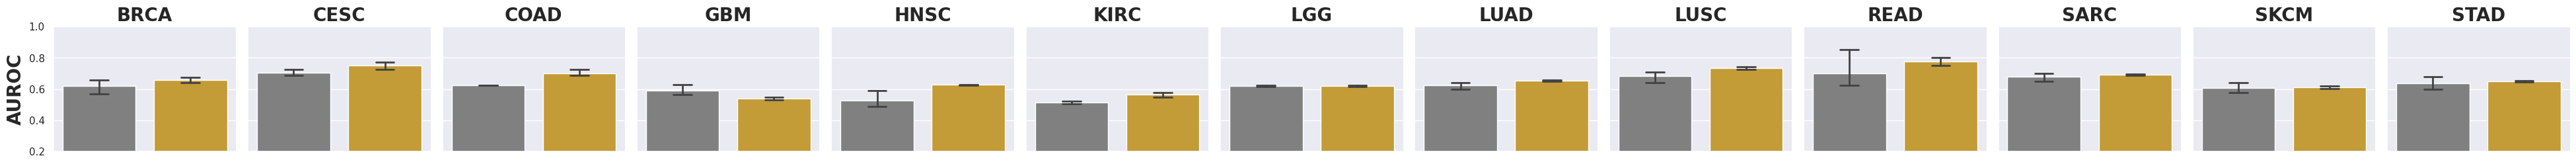

In [72]:
method_list = method_index #['all_all','match_all','all_match','match_match']
color_list = ['grey',"goldenrod",'mediumpurple','rebeccapurple',
              #'purple','palegreen','limegreen','seagreen','darkgreen','orange','blue',
                'lightgray'][:len(method_list)]

palette ={method_list[i]:color_list[i] for i in range(len(method_list))}
plt.figure(figsize=(10, 12))
sns.set(font_scale = 3.5)
sns.set(rc={'figure.figsize':(6,14)})

g= sns.FacetGrid(result_df.loc[result_df.metric=='AUC'], col="Tumor_type", col_wrap=14, height=3)
g.map_dataframe(sns.barplot, x='method', y='auroc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=20, weight='bold')
g.set(ylim=(0.2,1.0))
g.set_xlabels('')
g.set_ylabels('AUROC', size=20, weight='bold')
g.set_xticklabels("")
# plt.legend(loc='upper right', bbox_to_anchor=(1.75, 0.85), fontsize=15)
# plt.show()
plt.savefig('../results/use_result/output/P_MDL_tcga_TT.pdf',format = 'pdf',dpi=600,bbox_inches='tight')
plt.show()

ae_norm
dsrn_norm
ae_mmd_norm
dsrn_mmd_norm
dsn_mmd_norm
ae_adv_norm
dsrn_adv_norm
dsn_adv_norm


<Figure size 1000x1200 with 0 Axes>

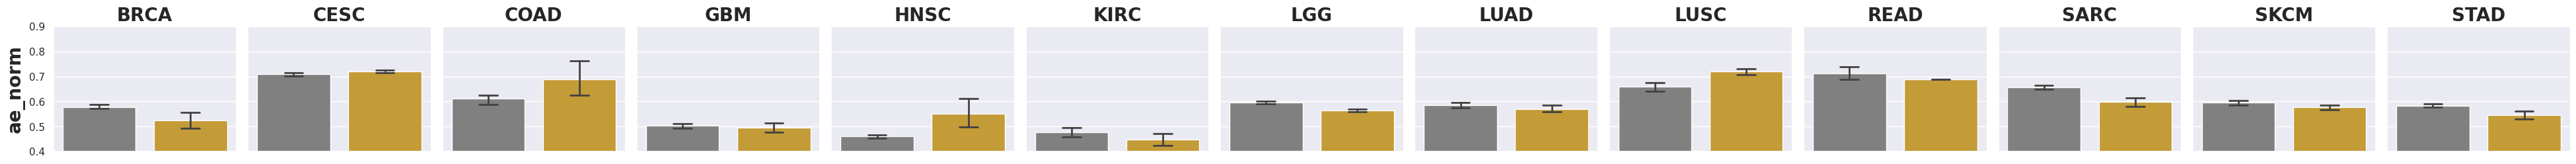

<Figure size 1000x1200 with 0 Axes>

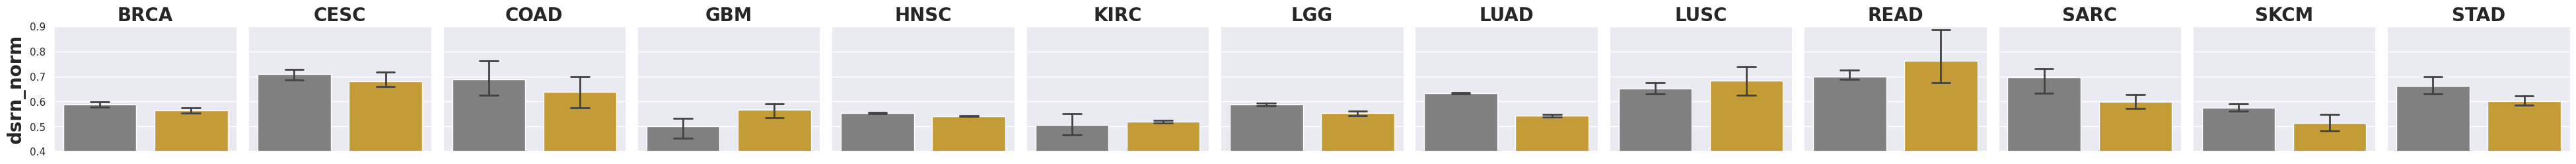

<Figure size 1000x1200 with 0 Axes>

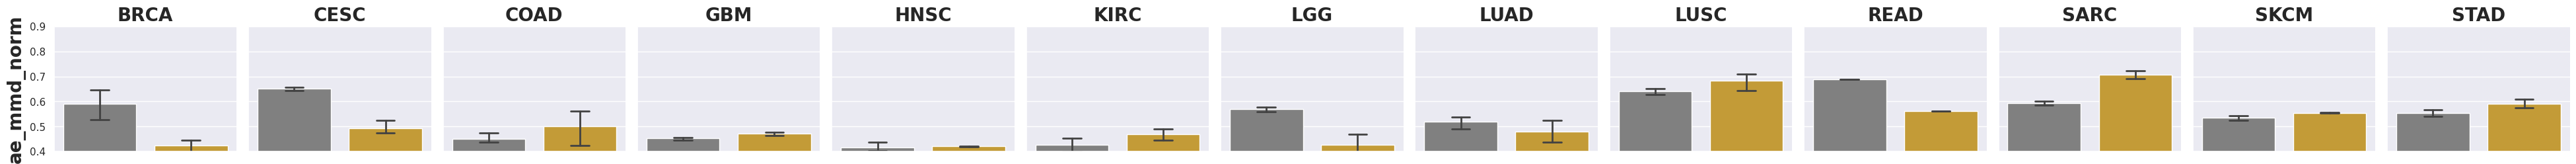

<Figure size 1000x1200 with 0 Axes>

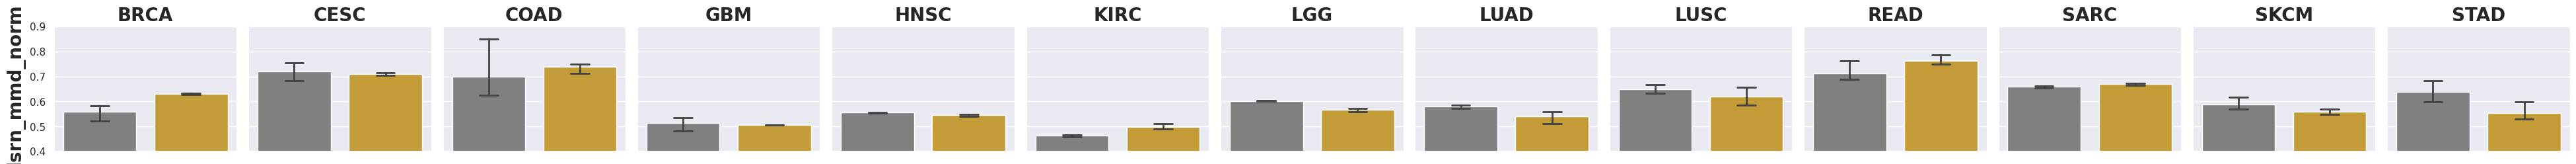

<Figure size 1000x1200 with 0 Axes>

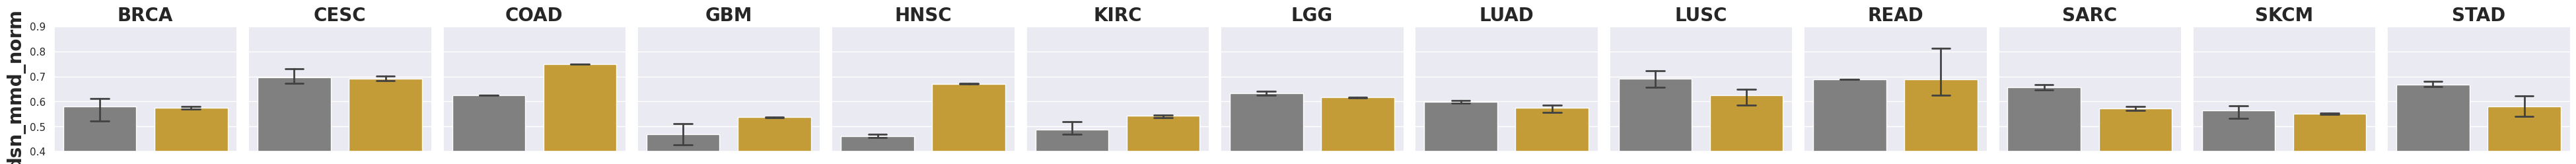

<Figure size 1000x1200 with 0 Axes>

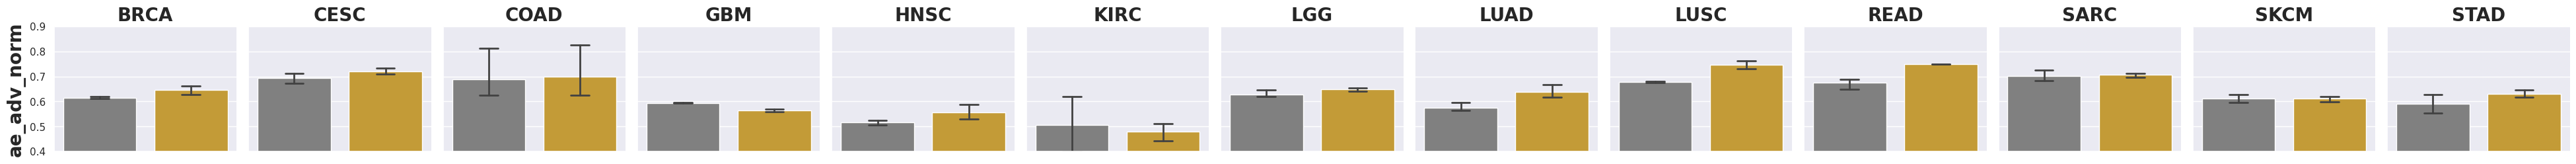

<Figure size 1000x1200 with 0 Axes>

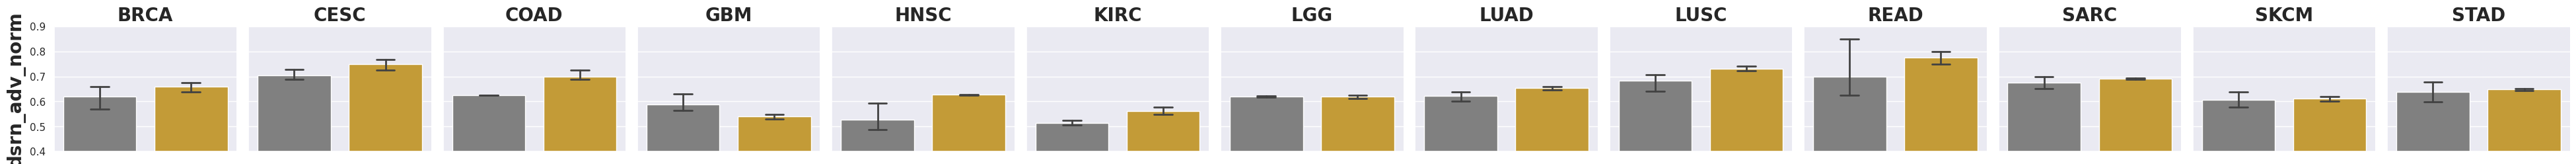

<Figure size 1000x1200 with 0 Axes>

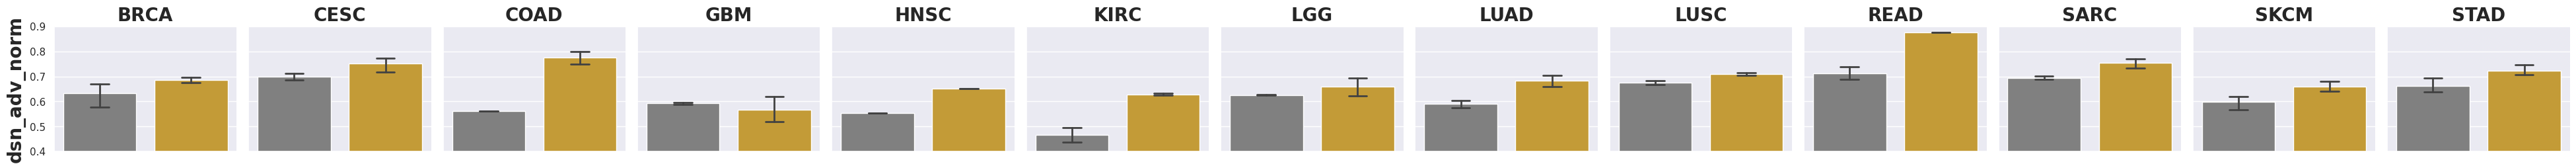

In [103]:
b = pd.DataFrame()
model_list = ['ae','dsrn', 
                       'ae_mmd','dsrn_mmd','dsn_mmd',
                       'ae_adv','dsrn_adv','dsn_adv']
for select_method in model_list:
  select_method = select_method + "_norm"
  print(select_method)
  auc_ft_report, auc_ft_report_std, auc_ft_result_dict = generate_best_params(
          pc="raw",cc="raw",
          sdm = "overlap",method = select_method,pdtc_flag=False, folder=dir_name,metric_name='auroc', measurement='AUC')
  auc_ft_report

  increase = -auc_ft_report.pct_change(periods=-1,axis=0).iloc[0,:]
  a = auc_ft_report.iloc[:2,:].append(increase*100)
  a.index = ['all_all','match_all','increase%']
  a.to_csv(f'../results/use_result/tcga_TT/{select_method}.csv')

  b = b.append(a.iloc[2,:])

  ZDS = [element.upper() for element in Tumor_type_list]
  result_df = None
  for cat in ZDS:
      temp_df = pd.DataFrame.from_dict(auc_ft_result_dict[cat])

      temp_df = pd.melt(temp_df)
      temp_df['Tumor_type'] = cat
      temp_df['metric'] = 'AUC'
      result_df = pd.concat((result_df, temp_df))
          
  result_df = result_df.rename(columns={'variable': 'method', 'value': 'auroc'})
  method_order = method_index
  result_df.method = result_df.method.astype('category')
  result_df.method.cat.set_categories(method_order, inplace=True)
  result_df.sort_values(by='method', inplace=True)

  TT_order = ZDS
  result_df.Tumor_type = result_df.Tumor_type.astype('category')
  result_df.Tumor_type.cat.set_categories(TT_order, inplace=True)
  result_df.sort_values(by='Tumor_type', inplace=True)


  method_list = method_index #['all_all','match_all','all_match','match_match']
  color_list = ['grey',"goldenrod",'mediumpurple','rebeccapurple',
                #'purple','palegreen','limegreen','seagreen','darkgreen','orange','blue',
                  'lightgray'][:len(method_list)]

  palette ={method_list[i]:color_list[i] for i in range(len(method_list))}
  plt.figure(figsize=(10, 12))
  sns.set(font_scale = 3.5)
  sns.set(rc={'figure.figsize':(6,14)})

  g= sns.FacetGrid(result_df.loc[result_df.metric=='AUC'], col="Tumor_type", col_wrap=14, height=3)
  g.map_dataframe(sns.barplot, x='method', y='auroc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
  g.despine()
  g.set_titles('{col_name}', size=20, weight='bold')
  g.set(ylim=(0.4,0.9))
  g.set_xlabels('')
  g.set_ylabels(select_method, size=20, weight='bold')
  g.set_xticklabels("")
  # plt.legend(loc='upper right', bbox_to_anchor=(1.75, 0.85), fontsize=15)
  # plt.show()
  plt.savefig(f'../results/use_result/tcga_TT/{select_method}.pdf',format = 'pdf',dpi=600,bbox_inches='tight')

In [104]:

b.index = model_list
# b.columns = Tumor_type_list
b



,BRCA,CESC,COAD,GBM,HNSC,KIRC,LGG,LUAD,LUSC,READ,SARC,SKCM,STAD
ae,-10.097087,1.544402,10.909091,-1.425178,16.379310,-6.310680,-5.509726,-3.200000,8.611111,-3.636364,-9.495549,-3.277236,-6.666667
dsrn,-3.978300,-4.498978,-7.843137,11.579572,-2.116788,2.517483,-6.512015,-16.759777,4.398827,8.196721,-16.493314,-11.452652,-10.207101
ae_mmd,-39.182692,-32.112676,10.000000,4.001429,1.222954,8.880309,-33.198925,-7.886435,6.432749,-22.222222,15.869018,3.454629,6.315789
dsrn_mmd,11.326861,-1.565558,5.084746,-1.728149,-1.960784,7.334786,-6.294416,-7.282913,-4.838710,6.557377,1.593625,-5.395519,-15.064103
dsn_mmd,-0.709220,-0.803213,16.666667,12.824523,31.330978,10.294118,-2.656104,-4.221636,-10.223642,-0.000000,-14.751553,-2.176934,-15.337423
ae_adv,4.739336,3.853565,1.785714,-5.363528,7.117438,-5.362538,3.075080,9.952607,9.115282,10.000000,0.755668,-0.208943,6.214689
dsrn_adv,6.046512,5.925926,10.714286,-8.955224,15.962145,8.510638,0.120415,4.872390,6.557377,9.677419,2.059202,0.874636,1.646091
dsn_adv,7.451565,7.024030,27.419355,-4.634581,15.109223,25.821326,5.280097,13.555556,5.070423,18.571429,8.009423,9.470429,8.487085


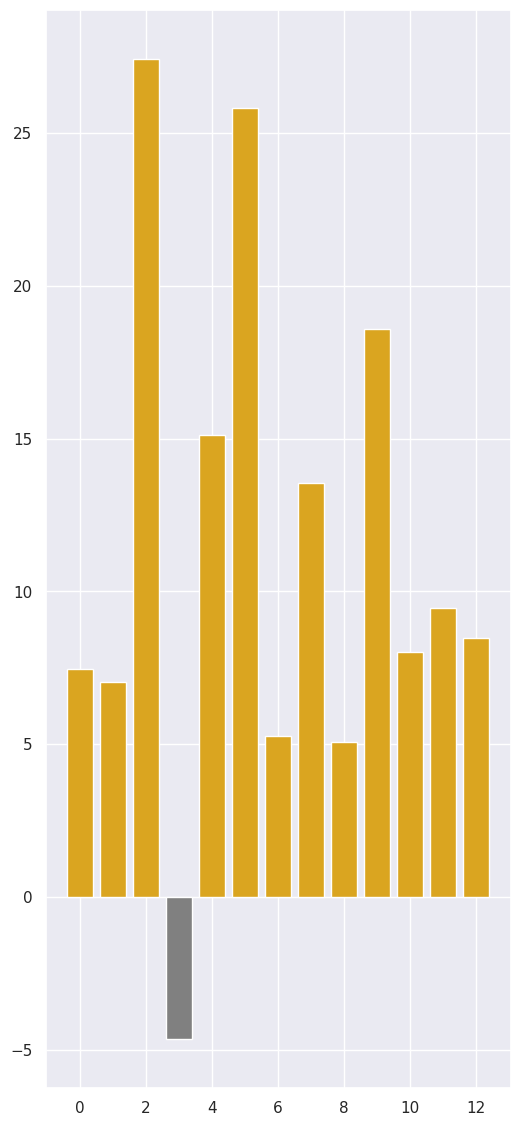

In [98]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = np.arange(len(Tumor_type_list))
y = b.iloc[9,:].values
ax.bar(x[y>=0], y[y>=0], color='goldenrod')
ax.bar(x[y<0], y[y<0], color='grey')

plt.show()

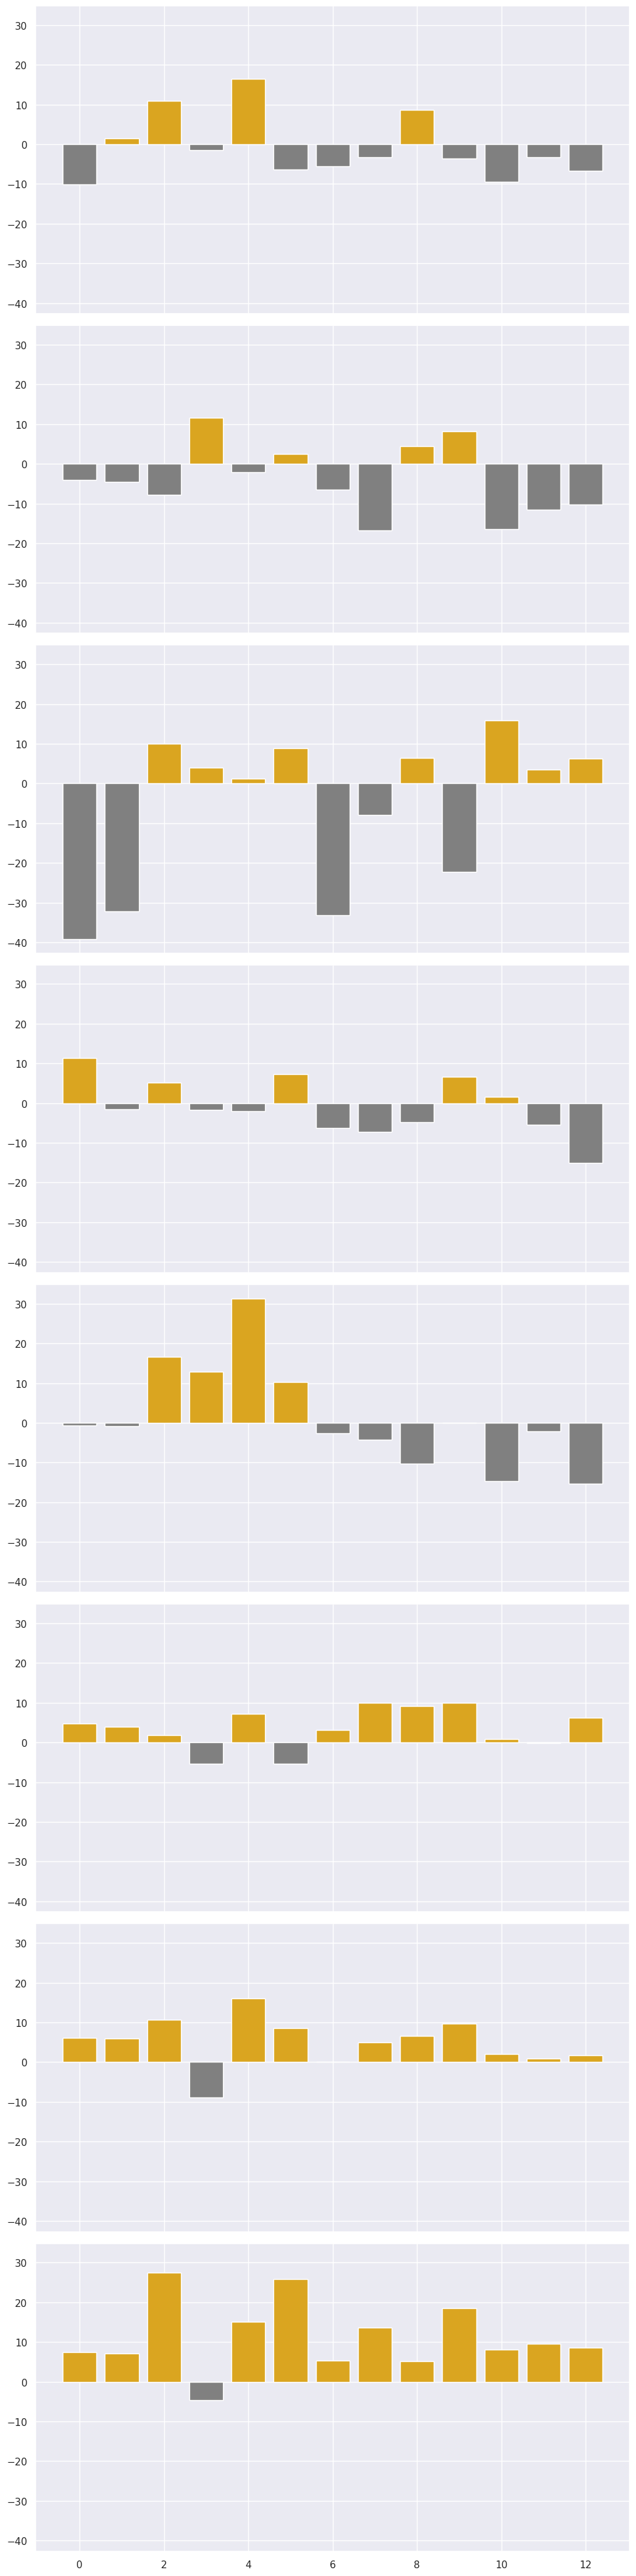

In [105]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(len(model_list), 1, figsize=(10, 40), sharex=True, sharey=True)
x = np.arange(len(Tumor_type_list))

for i in range(len(model_list)):
    y=b.iloc[i,:].values
    axs[i].bar(x, y)
    axs[i].bar(x[y>=0], y[y>=0], color='goldenrod')
    axs[i].bar(x[y<0], y[y<0], color='grey')

plt.tight_layout()
plt.savefig(f'../results/use_result/tcga_TT/tongji.pdf',format = 'pdf',dpi=600,bbox_inches='tight')

## For Methods Comp

In [1]:
method_list = [x + "_norm" for x in ['ae','dae','vae','ae_mmd','ae_adv', #ae_mmd:3
                       'dsn_mmd','dsn_adv','dsn_adnn',
                       'dsrn','dsrn_mmd','dsrn_adv','dsrn_adnn']]
method_list = [x + "_norm" for x in ['ae','dsrn', 
                       'ae_mmd','dsrn_mmd','dsn_mmd',
                       'ae_adv','dsrn_adv','dsn_adv']]
# method_index = ["all_all","match_all"]

# dir_name = '../results/yes'  #dir_name = '../results/no_drug_embed_model/'
dir_name = '../results/final_1'


Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc","kich","kirc","kirp", "lgg",
          "luad", "lusc",  "read", "sarc", "skcm","stad"] #CCL多的
# Tumor_type_list = ["kich","kirc","kirp","lihc","prad"]  ##CCL少的
Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc","kirc","lgg",
          "luad", "lusc", "read", "sarc", "skcm","stad"]
import pandas as pd
import torch
import json
import os
import argparse
import random
import pickle
import numpy as np
from collections import defaultdict
from operator import itemgetter
from scipy.stats import rankdata
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import gzip
from pprint import pprint
from scipy.stats import ttest_ind
#from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster import KMeans
from sklearn import manifold
import data
import data_config
import warnings
import re
from collections import Counter
warnings.filterwarnings("ignore")

def reverse_rankdata(a):
    return rankdata([-1 * i for i in a]).astype(int)

def generate_p_val(a, b):
    t, p = ttest_ind(a, b, equal_var=False)
    print("ttest_ind:            t = %g  p = %g" % (t, p))


def get_largest_kv(d, std_dict):
    k = max(d.items(), key=itemgetter(1))[0]
    return k, d[k], std_dict[k]

def parse_param_str(param_str):
    pattern = re.compile('(pretrain_num_epochs)?_?(\d+)?_?(train_num_epochs)_(\d+)_(dop)_(\d\.\d)')
    matches = pattern.findall(param_str)
    return {matches[0][i]: float(matches[0][i+1]) for i in range(0,len(matches[0]), 2) if matches[0][i] != ''}

def parse_ft_evaluation_result(file_name, method, pds,pc,sgm,ct,cc,zds,cds,sdm,folder,measurement='AUC',metric_name='auroc',pdtc_flag=False):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc/'
    else:
        folder = f'{folder}/{method}/{pds}/{pc}/{sgm}/{ct}/{cc}/{zds}/{cds}/{sdm}/{measurement}/'        
    with open(os.path.join(folder, file_name), 'r') as f:
        result_dict = json.load(f)
    if 'enet' in result_dict:
        result_dict = result_dict['enet'][0]
    return result_dict[metric_name]


#已经在一组参数内求完均值了，正常有预训练和训练的共3*10*2=60组
def parse_hyper_ft_evaluation_result(method,pds,pc,sgm,ct,cc,zds,cds,sdm,folder, measurement='AUC',metric_name='auroc', pdtc_flag = False):
    if pdtc_flag:
        folder = f'{folder}/{method}/{measurement}/pdtc'
    else:
        folder = f'{folder}/{method}/{pds}/{pc}/{sgm}/{ct}/{cc}/{zds}/{cds}/{sdm}/{measurement}'        
    evaluation_metrics = {}
    evaluation_metrics_std = {}
    evaluation_metrics_count = {}
    count = 0
    for file in os.listdir(folder):
        if re.match('(pretrain|train)+.*(dop+).*(ft)+.*\.json', file) or file == 'ft_evaluation_results.json':
            count += 1
            with open(os.path.join(folder, file), 'r') as f:
                result_dict = json.load(f)
            
            if 'enet' in result_dict:
                result_dict = result_dict['enet'][0]
            
            evaluation_metrics[file] = np.mean(result_dict[metric_name])
            evaluation_metrics_std[file] = np.std(result_dict[metric_name])
            evaluation_metrics_count[file] = len(Counter(result_dict[metric_name]))/len(result_dict[metric_name])
    # to_exclude = []
    # for k, v in evaluation_metrics_count.items():
    #     if v < 0.5: 
    #         to_exclude.append(k)
            
    # if len(to_exclude)>0:
    #     for k in to_exclude:
    #         evaluation_metrics.pop(k)
    #         evaluation_metrics_std.pop(k)
                    
    return evaluation_metrics, evaluation_metrics_std, count
            

#新写一个函数，得到adv中最好的order
def generate_best_params(folder,pds = "match",pc="raw",cc="raw",ct = "all_CCL" ,sgm = "Percent_sd",cds = "gdsc1_raw",sdm = "overlap",metric_name='auroc', measurement='AUC', pdtc_flag=False):
    # methods = ['enet','rf','cell_enet','mlp','ae','dae_norm', 'vae','vaen','coxen','coxrf','coral_norm', 'adae_norm','velodrome', 'tcrp','dsna_norm','dsn_norm','code_adv_norm','deconvolution']
    # Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kich", "kirc", "kirp", 
    #       "luad", "lusc", "paad", "prad", "read", "sarc", "skcm"]
    # Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc",  "kirc", "kirp", 
    #       "luad", "lusc", "paad", "prad",  "sarc"] #unlabel data > 100
    # Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kich", "kirc", "kirp", 
    #      "lgg", "lihc", "luad", "lusc", "ov", "paad", "prad", "read", "sarc", "skcm", "stad"]
    ZDS = [element.upper() for element in Tumor_type_list]

    report = pd.DataFrame(np.zeros((len(method_list), len(ZDS))),index=[method_list],columns=ZDS)
    report_std = pd.DataFrame(np.zeros((len(method_list), len(ZDS))), index=[method_list],columns=ZDS)
    param_list = pd.DataFrame(np.zeros((len(method_list), len(ZDS))), index=[method_list],columns=ZDS)
    result_dict = defaultdict(dict)

    for zds in ZDS:        
        for method in method_list:
            # print(f'{method}: {cat}')
            folder = f'{folder}/{method}'
            if pds == "tcga":
                pds = "tcga"
            else:
                pds = zds.lower()
            try:            
                ave,std,count1 = parse_hyper_ft_evaluation_result(method=method,pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,metric_name=metric_name, measurement=measurement, pdtc_flag=pdtc_flag,folder=dir_name)
                param_str, report.loc[method,zds], report_std.loc[method,zds] = get_largest_kv(d = ave,
                                                                                        std_dict = std)
                param_list.loc[method,zds] = param_str
                # print(pds,"to",zds,param_str," : ",
                #     report.loc[method,zds], report_std.loc[method,zds]
                #     )
                result_dict[zds][method] = parse_ft_evaluation_result(file_name = param_str, 
                                                                            method=method, pds=pds,pc=pc,sgm=sgm,ct=ct,cc=cc,zds=zds,cds=cds,sdm=sdm,
                                                                            metric_name=metric_name, 
                                                                            measurement=measurement, 
                                                                            pdtc_flag=pdtc_flag,
                                                                            folder=dir_name)
            except Exception as e:
                    print(e)
                
    return report, report_std, result_dict, param_list





/opt/conda/envs/python3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#得到最好的参数
# dir_name = '../results/no_drug_embed_model/'
# dir_name = '../results/test_fenlei_for_com/'
# select_method = ['code_adv', 'dsn', 'dsna','code_base', 'code_mmd', 'adae', 'coral', 'dae', 'vae', 'ae'][0] + "_norm"
select_pds = ["tcga","match"][1]
select_ct = ["all_CCL","single_CCL"][0]

auc_ft_report, auc_ft_report_std, auc_ft_result_dict,param_list = generate_best_params(
        pds = select_pds,ct = select_ct,
        sdm = "overlap",pdtc_flag=False, folder=dir_name,metric_name='auroc', measurement='AUC')
#
param_list.to_csv(f'{dir_name}/param_list_{select_pds}.csv')


In [6]:
# param_list.to_csv(f'{dir_name}/param_list.csv')

'../results/final_1'

In [38]:
# param_list = pd.read_csv('../results/final_1/param_list.csv',index_col = 0)
# param_list

,BRCA,CESC,COAD,GBM,HNSC,LGG,LUAD,LUSC,READ,SARC,SKCM,STAD
ae_norm,train_num_epochs_750_dop_0.1_ft_evaluation_res...,train_num_epochs_100_dop_0.1_ft_evaluation_res...,train_num_epochs_300_dop_0.0_ft_evaluation_res...,train_num_epochs_2500_dop_0.1_ft_evaluation_re...,train_num_epochs_200_dop_0.0_ft_evaluation_res...,train_num_epochs_3000_dop_0.0_ft_evaluation_re...,train_num_epochs_100_dop_0.1_ft_evaluation_res...,train_num_epochs_3000_dop_0.1_ft_evaluation_re...,train_num_epochs_750_dop_0.1_ft_evaluation_res...,train_num_epochs_750_dop_0.0_ft_evaluation_res...,train_num_epochs_3000_dop_0.1_ft_evaluation_re...,train_num_epochs_2000_dop_0.0_ft_evaluation_re...
dsrn_norm,train_num_epochs_2500_dop_0.0_ft_evaluation_re...,train_num_epochs_2500_dop_0.0_ft_evaluation_re...,train_num_epochs_100_dop_0.0_ft_evaluation_res...,train_num_epochs_100_dop_0.1_ft_evaluation_res...,train_num_epochs_1000_dop_0.0_ft_evaluation_re...,train_num_epochs_1000_dop_0.0_ft_evaluation_re...,train_num_epochs_3000_dop_0.0_ft_evaluation_re...,train_num_epochs_100_dop_0.1_ft_evaluation_res...,train_num_epochs_300_dop_0.0_ft_evaluation_res...,train_num_epochs_300_dop_0.0_ft_evaluation_res...,train_num_epochs_3000_dop_0.0_ft_evaluation_re...,train_num_epochs_300_dop_0.0_ft_evaluation_res...
ae_mmd_norm,train_num_epochs_300_dop_0.1_ft_evaluation_res...,train_num_epochs_300_dop_0.1_ft_evaluation_res...,train_num_epochs_100_dop_0.0_ft_evaluation_res...,train_num_epochs_300_dop_0.1_ft_evaluation_res...,train_num_epochs_100_dop_0.0_ft_evaluation_res...,train_num_epochs_300_dop_0.1_ft_evaluation_res...,train_num_epochs_100_dop_0.0_ft_evaluation_res...,train_num_epochs_100_dop_0.0_ft_evaluation_res...,train_num_epochs_300_dop_0.1_ft_evaluation_res...,train_num_epochs_100_dop_0.0_ft_evaluation_res...,train_num_epochs_100_dop_0.0_ft_evaluation_res...,train_num_epochs_100_dop_0.0_ft_evaluation_res...
dsrn_mmd_norm,train_num_epochs_1500_dop_0.0_ft_evaluation_re...,train_num_epochs_2000_dop_0.0_ft_evaluation_re...,train_num_epochs_750_dop_0.1_ft_evaluation_res...,train_num_epochs_2500_dop_0.0_ft_evaluation_re...,train_num_epochs_300_dop_0.0_ft_evaluation_res...,train_num_epochs_2500_dop_0.1_ft_evaluation_re...,train_num_epochs_750_dop_0.0_ft_evaluation_res...,train_num_epochs_100_dop_0.1_ft_evaluation_res...,train_num_epochs_100_dop_0.0_ft_evaluation_res...,train_num_epochs_3000_dop_0.1_ft_evaluation_re...,train_num_epochs_100_dop_0.0_ft_evaluation_res...,train_num_epochs_1000_dop_0.1_ft_evaluation_re...
dsn_mmd_norm,train_num_epochs_200_dop_0.1_ft_evaluation_res...,train_num_epochs_2000_dop_0.0_ft_evaluation_re...,train_num_epochs_2000_dop_0.0_ft_evaluation_re...,train_num_epochs_750_dop_0.1_ft_evaluation_res...,train_num_epochs_1500_dop_0.0_ft_evaluation_re...,train_num_epochs_100_dop_0.0_ft_evaluation_res...,train_num_epochs_100_dop_0.0_ft_evaluation_res...,train_num_epochs_100_dop_0.1_ft_evaluation_res...,train_num_epochs_750_dop_0.0_ft_evaluation_res...,train_num_epochs_1500_dop_0.0_ft_evaluation_re...,train_num_epochs_1000_dop_0.0_ft_evaluation_re...,train_num_epochs_300_dop_0.1_ft_evaluation_res...
ae_adv_norm,pretrain_num_epochs_100_train_num_epochs_500_d...,pretrain_num_epochs_0_train_num_epochs_100_dop...,pretrain_num_epochs_100_train_num_epochs_2500_...,pretrain_num_epochs_300_train_num_epochs_2500_...,pretrain_num_epochs_0_train_num_epochs_2500_do...,pretrain_num_epochs_300_train_num_epochs_100_d...,pretrain_num_epochs_300_train_num_epochs_2000_...,pretrain_num_epochs_0_train_num_epochs_100_dop...,pretrain_num_epochs_300_train_num_epochs_1500_...,pretrain_num_epochs_100_train_num_epochs_2000_...,pretrain_num_epochs_300_train_num_epochs_2000_...,pretrain_num_epochs_100_train_num_epochs_200_d...
dsrn_adv_norm,pretrain_num_epochs_300_train_num_epochs_1000_...,pretrain_num_epochs_0_train_num_epochs_2500_do...,pretrain_num_epochs_0_train_num_epochs_3000_do...,pretrain_num_epochs_100_train_num_epochs_200_d...,pretrain_num_epochs_300_train_num_epochs_100_d...,pretrain

In [3]:

auc_ft_report.loc['adv/max'] = auc_ft_report.iloc[7,].div(auc_ft_report.max(axis=0))
auc_ft_report

# auc_ft_report.to_csv("../match_pretrain.csv")

auc_ft_report.loc['adv/max'] = auc_ft_report.iloc[0,].div(auc_ft_report.max(axis=0))
auc_ft_report

,BRCA,CESC,COAD,GBM,HNSC,KIRC,LGG,LUAD,LUSC,READ,SARC,SKCM,STAD
"(ae_norm,)",0.578571,0.708333,0.612500,0.502353,0.460079,0.476087,0.595231,0.586364,0.65800,0.7125,0.656000,0.594898,0.583111
"(dsrn_norm,)",0.586735,0.709722,0.687500,0.500504,0.552964,0.505072,0.588279,0.633333,0.65200,0.7000,0.696889,0.573469,0.662222
"(ae_mmd_norm,)",0.590816,0.651389,0.450000,0.451597,0.415020,0.427536,0.569377,0.518182,0.64000,0.6875,0.593778,0.534694,0.553778
"(dsrn_mmd_norm,)",0.559184,0.720833,0.700000,0.514454,0.554941,0.462319,0.601551,0.580303,0.65000,0.7125,0.658667,0.588010,0.638222
"(dsn_mmd_norm,)",0.579592,0.697222,0.625000,0.468403,0.460870,0.486232,0.632864,0.598485,0.69000,0.6875,0.656889,0.562755,0.668444
"(ae_adv_norm,)",0.615306,0.693056,0.687500,0.594286,0.515810,0.505435,0.627492,0.575758,0.67800,0.6750,0.700444,0.611735,0.590222
"(dsrn_adv_norm,)",0.618367,0.705556,0.625000,0.588908,0.526482,0.514130,0.619535,0.621212,0.68400,0.7000,0.676444,0.607143,0.637333
"(dsn_adv_norm,)",0.633673,0.698611,0.562500,0.591933,0.552964,0.466304,0.625625,0.589394,0.67400,0.7125,0.694222,0.597449,0.661333
adv/max,0.578571,0.730865,0.762222,0.504350,0.461723,0.524916,0.602119,0.630077,0.67362,0.7125,0.661880,0.609123,0.589381


In [3]:
#  pds=pds,sgm=sgm,zds=zds,cds=cds,sdm=sdm,
# Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc",  "kirc", "kirp", 
#           "luad", "lusc", "paad", "prad",  "sarc"] #unlabel data > 100
ZDS = [element.upper() for element in Tumor_type_list]

result_df = None
for cat in ZDS:
    temp_df = pd.DataFrame.from_dict(auc_ft_result_dict[cat])
    # temp_df = temp_df.rename(columns={'tcrp': 'TCRP',"dae_norm": "dae",'cell_enet':'CELLIGNER','dsn_norm':"dsn-mmd", 'dsna_norm': 'dsn-dann', 'code_adv_norm': 'code-ae-adv'})
    # temp_df = temp_df.rename(columns={k: k.upper() for k in temp_df.columns})

    temp_df = pd.melt(temp_df)
    temp_df['Tumor_type'] = cat
    temp_df['metric'] = 'AUC'
    result_df = pd.concat((result_df, temp_df))
        
result_df = result_df.rename(columns={'variable': 'method', 'value': 'auroc'})
method_order = method_list
result_df.method = result_df.method.astype('category')
result_df.method.cat.set_categories(method_order, inplace=True)
result_df.sort_values(by='method', inplace=True)

TT_order = ZDS
result_df.Tumor_type = result_df.Tumor_type.astype('category')
result_df.Tumor_type.cat.set_categories(TT_order, inplace=True)
result_df.sort_values(by='Tumor_type', inplace=True)
result_df


,method,auroc,Tumor_type,metric
0,ae_norm,0.556122,BRCA,AUC
33,dsrn_adv_norm,0.663265,BRCA,AUC
32,dsrn_adv_norm,0.658163,BRCA,AUC
3,ae_norm,0.484694,BRCA,AUC
2,ae_norm,0.556122,BRCA,AUC
...,...,...,...,...
21,dsn_mmd_norm,0.537778,STAD,AUC
20,dsn_mmd_norm,0.533333,STAD,AUC
23,dsn_mmd_norm,0.644444,STAD,AUC
38,dsn_adv_norm,0.720000,STAD,AUC


In [4]:
result_df.sort_values(by=['method','Tumor_type'], inplace=True)
# result_df.to_csv('/home/wuys/pdr3/results/use_result/P_MDL_tcga.txt')
result_df

,method,auroc,Tumor_type,metric
0,ae_norm,0.556122,BRCA,AUC
3,ae_norm,0.484694,BRCA,AUC
2,ae_norm,0.556122,BRCA,AUC
1,ae_norm,0.556122,BRCA,AUC
4,ae_norm,0.474490,BRCA,AUC
...,...,...,...,...
37,dsn_adv_norm,0.711111,STAD,AUC
36,dsn_adv_norm,0.768889,STAD,AUC
35,dsn_adv_norm,0.693333,STAD,AUC
38,dsn_adv_norm,0.720000,STAD,AUC


<Figure size 1000x1200 with 0 Axes>

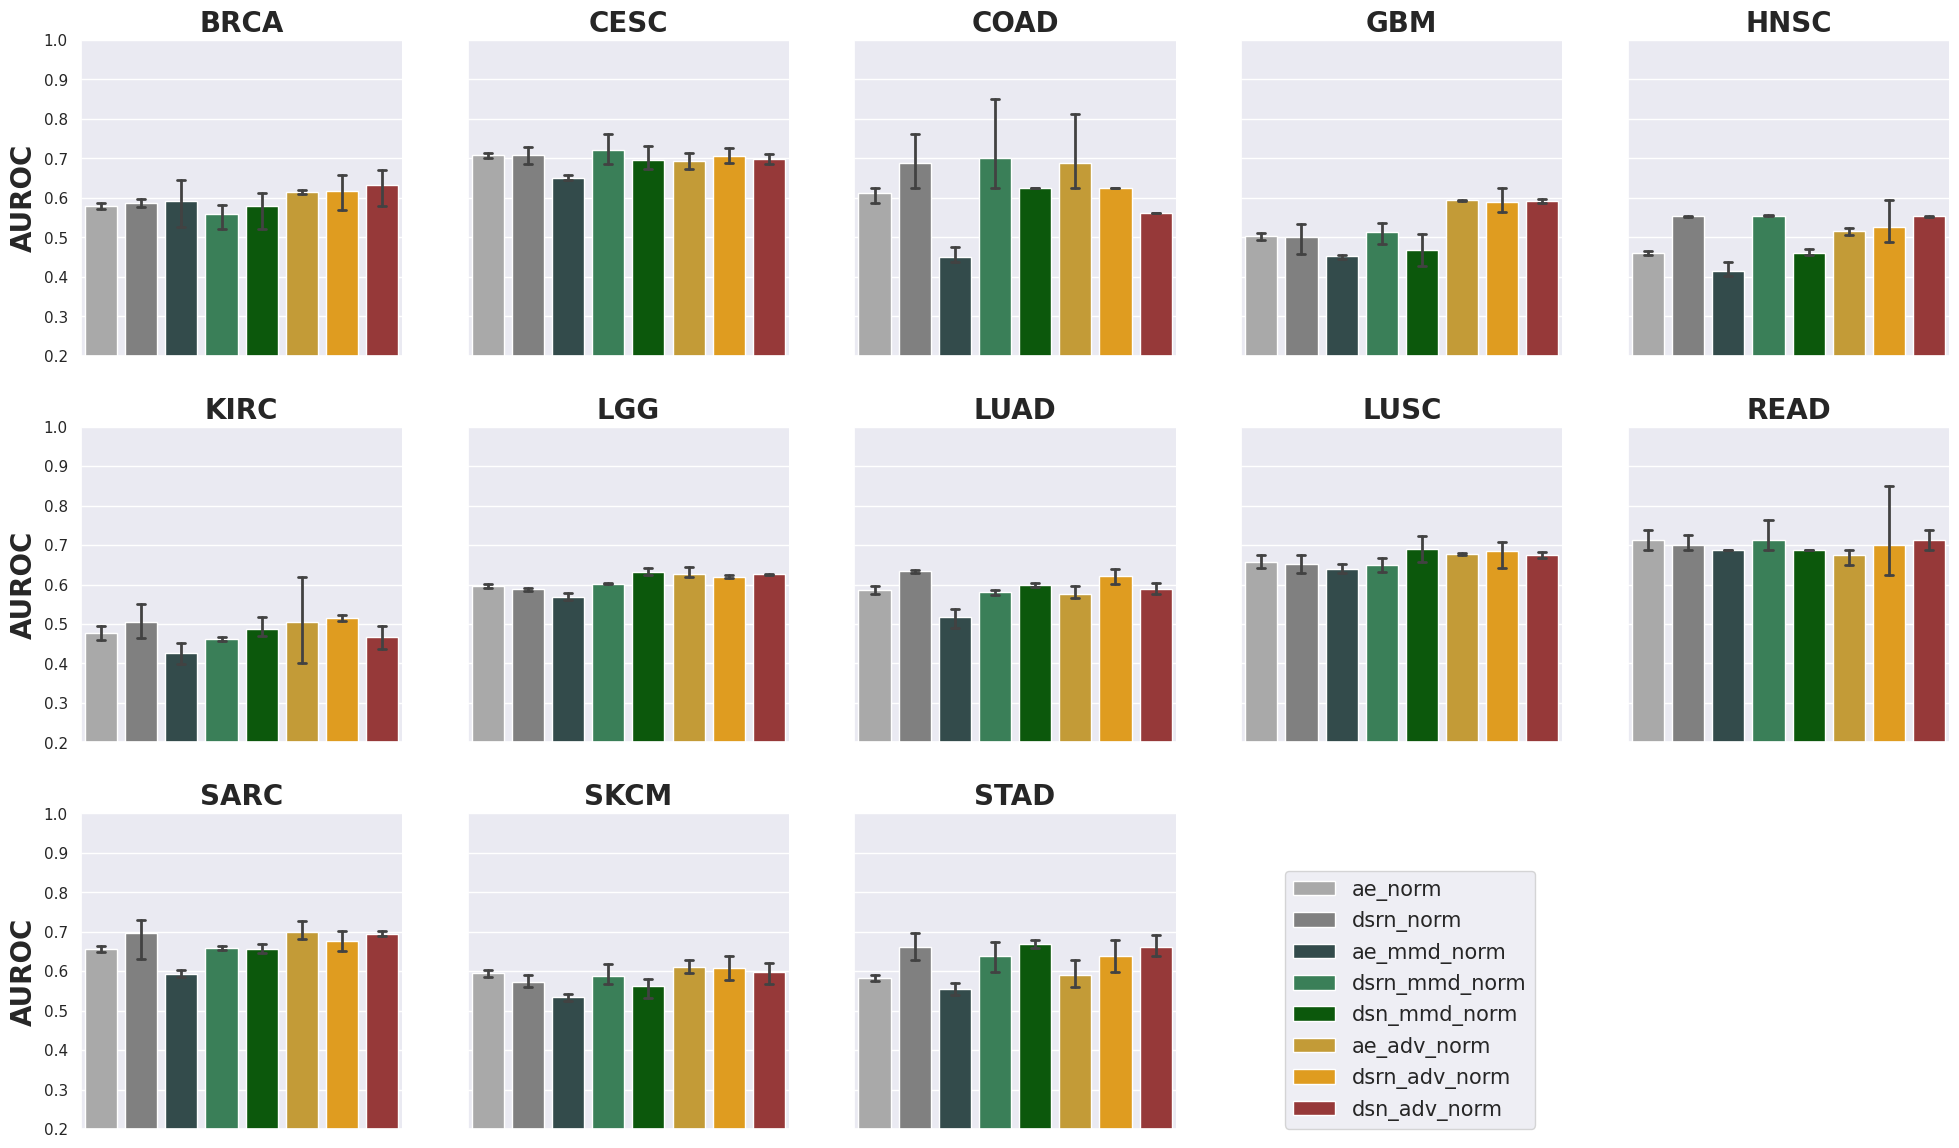

In [33]:
# method_list = [x + "_norm" for x in ['code_adv', 'dsn', 'dsna','code_base', 'code_mmd', 'adae', 'coral', 'dae', 'vae', 'ae']]
# import matplotlib
# plt = matplotlib.pyplot.gcf()
color_list = ['mediumpurple','purple','palegreen',
              'limegreen','seagreen','darkgreen','orange','blue', 'lightgray',
              'darkgray','darkslategray','gold','grey'][:len(method_list)]
color_list = ['darkgray','grey',
                'darkslategray','seagreen','darkgreen', #,'limegreen'
            #   'mediumpurple','purple',
              'goldenrod','orange','brown'] #,'gold'

palette ={method_list[i]:color_list[i] for i in range(len(method_list))}

plt.figure(figsize=(10, 12))
sns.set(font_scale = 3.5)
sns.set(rc={'figure.figsize':(6,14)})

g= sns.FacetGrid(result_df.loc[result_df.metric=='AUC'], col="Tumor_type", col_wrap=5, height=4)
g.map_dataframe(sns.barplot, x='method', y='auroc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=20, weight='bold')
g.set(ylim=(0.2,1.0))
g.set_xlabels('')
g.set_ylabels('AUROC', size=20, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(2.15, 0.85), fontsize=15)

plt.savefig('../results/use_result/tcga_pretrain.pdf',format = 'pdf',dpi=600,bbox_inches='tight')
# plt.show()
#plt.savefig('../paper/tcga_auc_bar.png', format='png', dpi=350,bbox_inches='tight')

In [5]:
# result_df
result_df_recon = pd.DataFrame(result_df.groupby(['method', 'Tumor_type'])['auroc'].mean())
# result_df_recon
result_df_recon.reset_index(inplace=True)
result_df_table = result_df_recon.pivot(index='method', columns='Tumor_type', values='auroc')
# # result_df_table = result_df_table.loc[['dsn', 'dsna', 'code_base','code_mmd','code_adv', 
# #                          'DrugCell_model', 'Paccmann_model', 'TGSA_model_mu','TGSA_model_exp',
# #        'TGSA_model_exp_mu',  'ae_norm']]
result_df_table

Tumor_type,BRCA,CESC,COAD,GBM,HNSC,KIRC,LGG,LUAD,LUSC,READ,SARC,SKCM,STAD
method,,,,,,,,,,,,,
ae_norm,0.525510,0.719444,0.6875,0.495294,0.550198,0.447826,0.564148,0.568182,0.720,0.6875,0.599111,0.576020,0.546667
dsrn_norm,0.564286,0.679167,0.6375,0.566050,0.541502,0.518116,0.552313,0.542424,0.682,0.7625,0.598222,0.514541,0.600889
ae_mmd_norm,0.424490,0.493056,0.5000,0.470420,0.420158,0.469203,0.427463,0.480303,0.684,0.5625,0.705778,0.553827,0.591111
dsrn_mmd_norm,0.630612,0.709722,0.7375,0.505714,0.544269,0.498913,0.565929,0.540909,0.620,0.7625,0.669333,0.557908,0.554667
dsn_mmd_norm,0.575510,0.691667,0.7500,0.537311,0.671146,0.542029,0.616490,0.574242,0.626,0.6875,0.572444,0.550765,0.579556
ae_adv_norm,0.645918,0.720833,0.7000,0.564034,0.555336,0.479710,0.647400,0.639394,0.746,0.7500,0.705778,0.610459,0.629333
dsrn_adv_norm,0.658163,0.750000,0.7000,0.540504,0.626482,0.561957,0.620282,0.653030,0.732,0.7750,0.690667,0.612500,0.648000
dsn_adv_norm,0.684694,0.751389,0.7750,0.565714,0.651383,0.628623,0.660500,0.681818,0.710,0.8750,0.754667,0.659949,0.722667


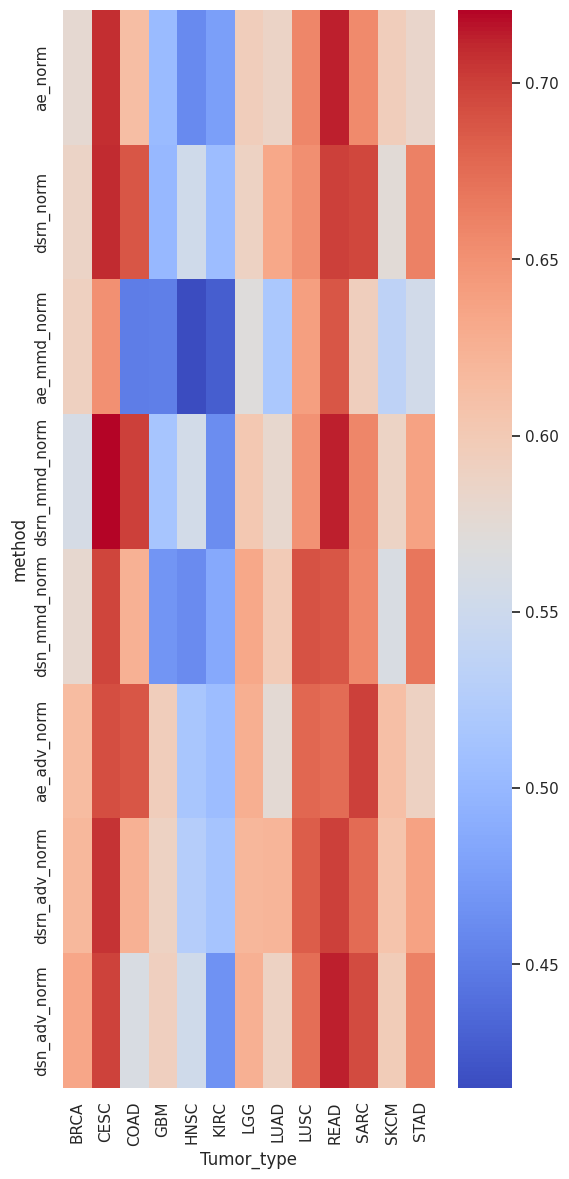

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# 将 DataFrame 转换为二维数组
# heatmap_data = pd.pivot_table(df, values='value', index='row', columns='column')

# 绘制热力图
sns.set_context(rc={'figure.figsize':(4,4)})  # 设置图像尺寸，宽度为 12 英寸，高度为 8 英寸
sns.heatmap(result_df_table, cmap='coolwarm')

# 设置图像属性
# plt.title('Heatmap Title')
# plt.xlabel('X Label')
# plt.ylabel('Y Label')
# plt.show()
plt.savefig('../results/use_result/output/P_MDL_tcga_all.pdf',format = 'pdf',dpi=600,bbox_inches='tight')

In [44]:
result_df_table.idxmax()

Tumor_type
BRCA     dsn_adv_norm
CESC    dsrn_mmd_norm
COAD    dsrn_mmd_norm
GBM       ae_adv_norm
HNSC    dsrn_mmd_norm
KIRC    dsrn_adv_norm
LGG      dsn_mmd_norm
LUAD        dsrn_norm
LUSC     dsn_mmd_norm
READ          ae_norm
SARC      ae_adv_norm
SKCM      ae_adv_norm
STAD     dsn_mmd_norm
dtype: object

In [51]:
# result_df_table.to_csv()
w = pd.concat([PP_table.iloc[0:10],result_df_table])
w

Tumor_type,BRCA,CESC,COAD,GBM,HNSC,KIRC,LGG,LUAD,LUSC,READ,SARC,SKCM,STAD
method,,,,,,,,,,,,,
dsn,0.400000,0.395833,0.5625,0.369412,0.502767,0.485507,0.458317,0.359091,0.634,0.4375,0.368889,0.466071,0.696000
dsna,0.372449,0.454167,0.5125,0.342185,0.451383,0.358333,0.470957,0.328788,0.674,0.7125,0.381333,0.459949,0.581333
code_base,0.334694,0.538889,0.6000,0.367563,0.501976,0.502174,0.473714,0.460606,0.626,0.7125,0.400889,0.498214,0.717333
code_mmd,0.518367,0.408333,0.6625,0.411261,0.424506,0.375362,0.566102,0.386364,0.536,0.7125,0.252444,0.500255,0.717333
code_adv,0.442857,0.304167,0.6125,0.494286,0.452964,0.511594,0.518529,0.409091,0.432,0.6500,0.427556,0.445408,0.648889
DrugCell_model,0.596939,0.623485,0.4000,0.490168,0.466403,0.578623,0.436369,0.589394,0.704,0.5375,0.536889,0.498724,0.432889
Paccmann_model,0.539796,0.573611,0.5875,0.469076,0.471937,0.484783,0.566274,0.471212,0.516,0.4500,0.504889,0.417602,0.574222
TGSA_model_mu,0.431122,0.615152,0.4250,0.460672,0.524111,0.607971,0.424217,0.590909,0.636,0.6250,0.541333,0.431122,0.414222
TGSA_model_exp,0.497449,0.550758,0.4000,0.443025,0.447233,0.591304,0.476271,0.506818,0.532,0.3625,0.499111,0.445153,0.545333


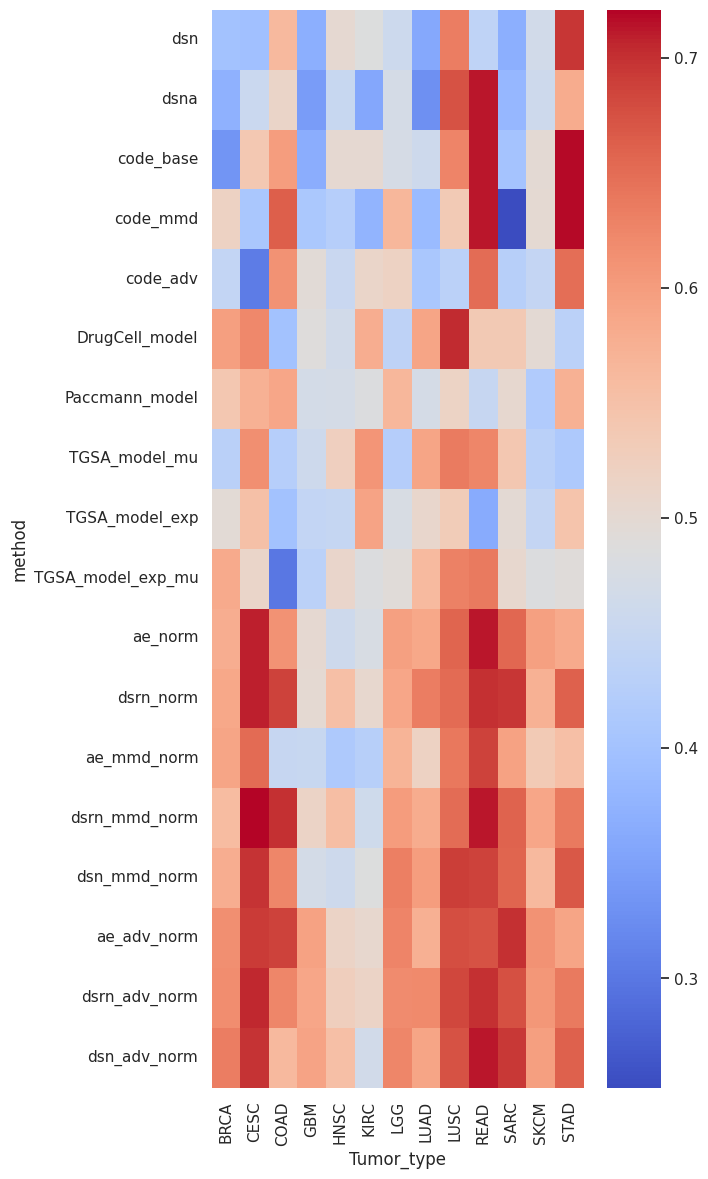

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# 将 DataFrame 转换为二维数组
# heatmap_data = pd.pivot_table(df, values='value', index='row', columns='column')

# 绘制热力图
sns.set_context(rc={'figure.figsize':(4,4)})  # 设置图像尺寸，宽度为 12 英寸，高度为 8 英寸
sns.heatmap(w, cmap='coolwarm')

# 设置图像属性
# plt.title('Heatmap Title')
# plt.xlabel('X Label')
# plt.ylabel('Y Label')
# plt.show()
plt.savefig('../results/use_result/output/all_tcga_all.pdf',format = 'pdf',dpi=600,bbox_inches='tight')

In [53]:
w.idxmax()

Tumor_type
BRCA      dsn_adv_norm
CESC     dsrn_mmd_norm
COAD     dsrn_mmd_norm
GBM        ae_adv_norm
HNSC     dsrn_mmd_norm
KIRC     TGSA_model_mu
LGG       dsn_mmd_norm
LUAD         dsrn_norm
LUSC    DrugCell_model
READ              dsna
SARC       ae_adv_norm
SKCM       ae_adv_norm
STAD          code_mmd
dtype: object

In [2]:
    #构建4级文件夹结构，并生成用于unlabel training需要的gex_features_df------
    import pandas as pd
    #Step1:Load gex and sample info file
    xena_gex_raw = pd.read_csv("../data/preprocessed_dat/xena_gex_raw.csv", index_col=0)  #TCGA_sample * 18966HVG(overlap)
    ccle_gex_raw = pd.read_csv("../data/preprocessed_dat/ccle_gex_raw.csv", index_col=0)  #CCL_sample * 18966HVG(overlap)

    xena_sample_info = pd.read_csv("../data/preprocessed_dat/xena_sample_info.csv", index_col=0) 
    ccle_sample_info = pd.read_csv("../data/preprocessed_dat/ccle_sample_info.csv", index_col=0) 
    
    


In [3]:
    #Step2:Locate selected tumor type for xena and CCL
    patient_tumor_type = "TCGA"
    if patient_tumor_type == "TCGA":
        xena_gex = xena_gex_raw
    else:
        xena_samples = xena_gex_raw.index.intersection(xena_sample_info.loc[xena_sample_info.tumor_type == patient_tumor_type].index)
        xena_gex = xena_gex_raw.loc[xena_samples]
    xena_gex


    if False:
        ccle_gex = ccle_gex_raw
    else:
        if patient_tumor_type == "TCGA":
            CCL_tumor_type = "BLCA"
        else:
            CCL_tumor_type = patient_tumor_type
        ccle_samples = ccle_gex_raw.index.intersection(ccle_sample_info.loc[ccle_sample_info.tumor_type == CCL_tumor_type].index)
        ccle_gex = ccle_gex_raw.loc[ccle_samples]

    ccle_gex

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,OR8B4,PCDH20,OR12D2,PRAMEF26,CCDC163,RPS4Y2,TMEM272,TMEM265,TEX13D,TEX13C
ACH-000545,4.251719,0.000000,5.651052,3.440952,3.275007,1.541019,6.659496,6.478648,5.566206,3.927896,...,0.000000,2.336283,0.000000,0.000000,2.965323,0.000000,0.000000,6.259837,0.000000,0.014355
ACH-000834,6.268846,0.000000,7.088947,1.992768,2.531069,0.028569,2.987321,5.452200,4.976364,3.723559,...,0.000000,0.014355,0.000000,0.000000,0.941106,0.000000,0.000000,4.356848,0.000000,0.014355
ACH-001411,5.432625,0.000000,6.579995,2.117695,4.059182,0.042644,4.751142,4.621173,6.575766,3.826803,...,0.000000,0.000000,0.000000,0.000000,1.422233,0.000000,0.000000,3.082362,0.000000,0.000000
ACH-000741,6.835040,0.000000,6.930383,1.469886,3.228049,0.084064,1.722466,7.002703,3.301588,4.989139,...,0.000000,0.910733,0.000000,0.000000,3.025029,0.000000,0.000000,6.245838,0.000000,0.014355
ACH-001416,5.781097,0.000000,6.913727,3.430285,4.151372,0.042644,2.250962,6.175724,5.674687,4.025915,...,0.000000,0.000000,0.000000,0.000000,1.389567,0.000000,0.000000,4.462707,0.000000,0.000000
ACH-001414,3.891419,0.014355,6.032982,2.482848,2.247928,0.443607,6.202614,4.530445,3.814550,4.574102,...,0.000000,0.028569,0.000000,0.000000,1.150560,0.000000,0.000000,2.508429,0.000000,0.028569
ACH-001407,5.266787,0.000000,7.391716,1.757023,4.777157,0.070389,1.608809,6.747119,4.685940,3.802193,...,0.000000,0.000000,0.000000,0.000000,1.077243,0.000000,0.000000,1.356144,0.056584,0.000000
ACH-001183,5.907612,0.000000,7.605924,2.454176,4.649615,0.275007,5.239169,4.678635,5.128871,4.672991,...,0.000000,0.014355,0.000000,0.000000,1.500802,0.000000,0.000000,2.845992,0.000000,0.000000
ACH-001410,5.972463,0.321928,7.438293,2.974529,3.969933,0.028569,0.014355,7.003602,5.989820,3.919340,...,0.000000,0.000000,0.000000,0.000000,1.996389,0.000000,0.056584,3.295723,0.000000,0.000000
ACH-001413,5.073392,0.000000,7.706738,2.709291,4.766065,0.056584,1.480265,7.035734,4.485427,4.246408,...,0.000000,0.176323,0.000000,0.000000,2.087463,0.000000,0.028569,2.918386,0.000000,0.000000


In [4]:
    import numpy as np
    gex = ccle_gex
    def unique_percent(x):
        return len(x.unique()) / len(x)
    cancer_unique = gex.apply(unique_percent)
    cancer_sd = gex.apply(np.std)
    percent_sd = cancer_unique*cancer_sd
    a = percent_sd.sort_values(ascending=False).index[:1000].values

In [8]:
a.shape

(1000,)

In [46]:
    patient_gex = xena_gex
    union_gene=list(set(a).union(set(a)))
    from sklearn import preprocessing
    patient_gex_new = patient_gex.loc[:,union_gene] 
    patient_gex_nor = pd.DataFrame(preprocessing.scale(patient_gex_new),index=patient_gex_new.index,columns=patient_gex_new.columns)
    ccle_gex_new = ccle_gex.loc[:,union_gene]
    ccle_gex_nor = pd.DataFrame(preprocessing.scale(ccle_gex_new),index=ccle_gex_new.index,columns=ccle_gex_new.columns)

    combine_gex = pd.concat([patient_gex_nor,ccle_gex_nor])
    combine_gex

,GATA3,GLUL,ASS1,TMEM184A,PLAC8,CYP1A1,FAT2,KLK6,LRATD2,MAP7,...,IFI27,TNNT1,C6orf132,CPVL,TNFRSF21,PTGS2,MRC2,DAB2,GAMT,ADGRG6
TCGA-19-1787-01,-0.881942,1.015737,-0.366389,-1.503148,-0.451359,-0.267591,-0.614998,1.417261,-0.927470,-0.401151,...,1.082473,-0.229937,-1.588490,1.187353,-0.193274,-0.912694,0.797622,-0.443935,0.283715,-0.988873
TCGA-S9-A7J2-01,-0.996097,1.306145,-1.994952,-1.562823,-0.905549,0.895977,-0.571218,0.018127,1.421816,-0.812791,...,-0.889753,0.462137,-1.602727,-0.260326,0.838279,-0.757870,-0.751343,-0.503208,0.725583,-1.129657
TCGA-EK-A2RE-01,-0.273890,0.080231,0.161232,1.742541,-0.734919,-0.281232,2.483923,1.661436,-0.520503,0.722890,...,0.833899,1.603731,1.350100,-1.284717,0.091971,0.107281,0.157960,-1.478477,-0.586314,1.170585
TCGA-44-6778-01,-0.023928,1.296400,-0.323711,-0.478296,0.943186,-0.308896,-0.592808,-0.775900,0.389401,-0.177511,...,0.181945,0.194500,-0.174028,1.297807,-0.081144,1.599467,0.269992,1.139788,-0.683534,1.178294
TCGA-F4-6854-01,-0.725957,-0.401810,1.403095,1.237592,0.741997,-0.322931,-0.653419,0.639545,0.200861,0.647228,...,0.222038,-0.921799,1.479513,-0.636542,0.525912,0.264531,-0.251296,0.164145,-1.495103,-0.660655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-000486,-0.297867,-0.613806,-0.613773,0.459344,-1.254579,-0.611297,-0.206282,-0.845460,-0.499999,0.353760,...,-0.654539,0.700372,-0.486685,0.806972,-0.324140,-0.864317,0.389833,-0.778771,0.497899,0.322950
ACH-000802,-0.219748,1.217828,0.873167,0.022001,0.430596,-0.267478,0.754290,-0.040848,1.565429,0.830850,...,0.601921,-0.535402,0.330315,0.838674,0.083134,0.812569,-0.648471,-0.887913,0.537459,-0.882802
ACH-000720,0.433530,-1.876015,1.682415,-0.021413,0.640697,-0.776580,-0.739867,-0.797333,-0.303028,-0.941777,...,0.511427,0.784899,0.200310,-1.260668,0.794927,0.564859,1.381824,2.358979,0.336623,-2.377000
ACH-000142,0.808166,1.285334,-0.038220,1.575822,0.261109,0.133052,1.314132,1.314988,-0.346553,0.881194,...,0.878233,-0.424368,1.177587,-0.066385,1.058773,1.510069,0.128252,-0.629294,-0.326199,0.740056


: 

In [14]:
ZDS = [element.upper() for element in Tumor_type_list]
report = pd.DataFrame(np.zeros((len(method_list), len(ZDS))),index=[method_list],columns=ZDS)
report

,BRCA,CESC,COAD,GBM,HNSC,KICH,KIRC,LUAD,LUSC,PAAD,READ,SARC,SKCM,STAD
code_adv_norm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dsn_norm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dsna_norm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
code_base_norm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
code_mmd_norm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
adae_norm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dae_norm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vae_norm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ae_norm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
import pandas as pd
tcga_gex_feature_df = pd.read_csv("../data/preprocessed_dat/brca_uq1000_feature.csv", index_col=0) 
drug_emb = pd.read_csv("../data/preprocessed_dat/drug_embedding/CCL_dataset/supervised_infomax.pth300_results.csv",index_col=0)
drug_emb['Drug_smile']="a"

tcga_gex_feature_df['Drug_smile'] = "a"
tcga_gex_feature_df = tcga_gex_feature_df.iloc[:10]
tcga_gex_feature_df.reset_index(inplace=True)

tcga_drug_gex = tcga_gex_feature_df.merge(drug_emb,left_on="Drug_smile",right_on="Drug_smile") #gex,label(1),drug(300)
tcga_drug_gex.set_index("index",inplace=True)
del tcga_drug_gex['Drug_smile']

tcga_drug_gex


,VIM,KRT8,FN1,SPARC,KRT18,TGFBI,S100A6,KRT19,KRT7,SPINT2,...,drug_embedding_290,drug_embedding_291,drug_embedding_292,drug_embedding_293,drug_embedding_294,drug_embedding_295,drug_embedding_296,drug_embedding_297,drug_embedding_298,drug_embedding_299
index,,,,,,,,,,,,,,,,,,,,,
ACH-001097,0.685557,-1.888090,-1.636570,-1.301587,-1.973823,-1.47861,1.018730,-1.272999,-1.298762,-1.694685,...,0.141989,0.027653,0.099647,0.080194,0.115790,0.018105,0.017660,-0.163740,-0.212757,-0.168971
ACH-001097,0.685557,-1.888090,-1.636570,-1.301587,-1.973823,-1.47861,1.018730,-1.272999,-1.298762,-1.694685,...,0.004581,0.312608,-0.262713,0.115043,-0.063159,0.015820,-0.059779,0.005499,0.028456,0.560585
ACH-001097,0.685557,-1.888090,-1.636570,-1.301587,-1.973823,-1.47861,1.018730,-1.272999,-1.298762,-1.694685,...,0.150194,0.128895,-0.183226,0.137340,-0.178833,0.015276,-0.153505,0.241361,0.062713,0.211712
ACH-001097,0.685557,-1.888090,-1.636570,-1.301587,-1.973823,-1.47861,1.018730,-1.272999,-1.298762,-1.694685,...,0.019358,0.037102,-0.004048,-0.024658,0.067431,0.016093,0.107477,0.099496,-0.141661,0.161937
ACH-001097,0.685557,-1.888090,-1.636570,-1.301587,-1.973823,-1.47861,1.018730,-1.272999,-1.298762,-1.694685,...,-0.202018,0.203892,0.016081,0.158628,0.031966,0.013892,-0.014507,0.226647,0.044388,0.063534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-001617,-1.899966,-1.891951,-1.625779,-1.294516,-2.001350,-1.47861,-2.741909,-1.276500,-1.342550,-0.141128,...,-0.140878,-0.086610,-0.119396,-0.026429,-0.094796,0.016382,-0.092200,0.125974,-0.132637,-0.035869
ACH-001617,-1.899966,-1.891951,-1.625779,-1.294516,-2.001350,-1.47861,-2.741909,-1.276500,-1.342550,-0.141128,...,-0.012722,0.125333,-0.002148,-0.073811,0.072387,0.015147,0.037652,0.047836,-0.071441,0.058740
ACH-001617,-1.899966,-1.891951,-1.625779,-1.294516,-2.001350,-1.47861,-2.741909,-1.276500,-1.342550,-0.141128,...,0.065313,-0.009013,-0.087433,0.035280,-0.125418,0.016364,0.058834,0.000935,0.005960,0.071641


In [31]:
pdr_data_dateset = TensorDataset(
        torch.from_numpy(tcga_drug_gex.loc[:,~tcga_drug_gex.columns.str.startswith('drug_embedding')].values.astype('float32')), #gex:length-301
        torch.from_numpy(tcga_drug_gex.loc[:,tcga_drug_gex.columns.str.startswith('drug_embedding')].values.astype('float32')) #drug:300
        )

In [34]:
pdr_data_dateset

AttributeError: 'TensorDataset' object has no attribute 'index'

In [7]:
import pandas as pd
a = pd.read_csv('../results/rr.csv')
a

,Model,BRCA,CESC,COAD,GBM,HNSC,KICH,KIRC,KIRP,LGG,LUAD,LUSC,READ,SARC,SKCM,STAD
0,DrugCell,0.571429,0.439394,0.6250,0.526471,0.656126,NaN,0.454710,NaN,NaN,0.462121,0.440,0.4375,0.582222,0.452806,0.528889
1,Paccmann,0.647959,0.472222,0.6250,0.516807,0.422925,NaN,0.615942,NaN,NaN,0.272727,0.560,0.4375,0.542222,0.413265,0.466667
2,code_adv,0.442857,0.304167,0.6125,0.494286,0.452964,0.583333,0.511594,0.272222,0.518529,0.409091,0.432,0.6500,0.427556,0.445408,0.648889
3,code_mmd,0.518367,0.408333,0.6625,0.411260,0.424506,0.233333,0.375362,0.366667,0.566102,0.386364,0.536,0.7125,0.252444,0.500255,0.717333
4,dsn_adv,0.684694,0.751389,0.7750,0.565714,0.651383,0.783333,0.628623,0.538889,0.660500,0.681818,0.710,0.8750,0.754667,0.659949,0.722667


In [8]:
b = pd.melt(a,id_vars='Model')
b

,Model,variable,value
0,DrugCell,BRCA,0.571429
1,Paccmann,BRCA,0.647959
2,code_adv,BRCA,0.442857
3,code_mmd,BRCA,0.518367
4,dsn_adv,BRCA,0.684694
...,...,...,...
70,DrugCell,STAD,0.528889
71,Paccmann,STAD,0.466667
72,code_adv,STAD,0.648889
73,code_mmd,STAD,0.717333


<Figure size 1000x1200 with 0 Axes>

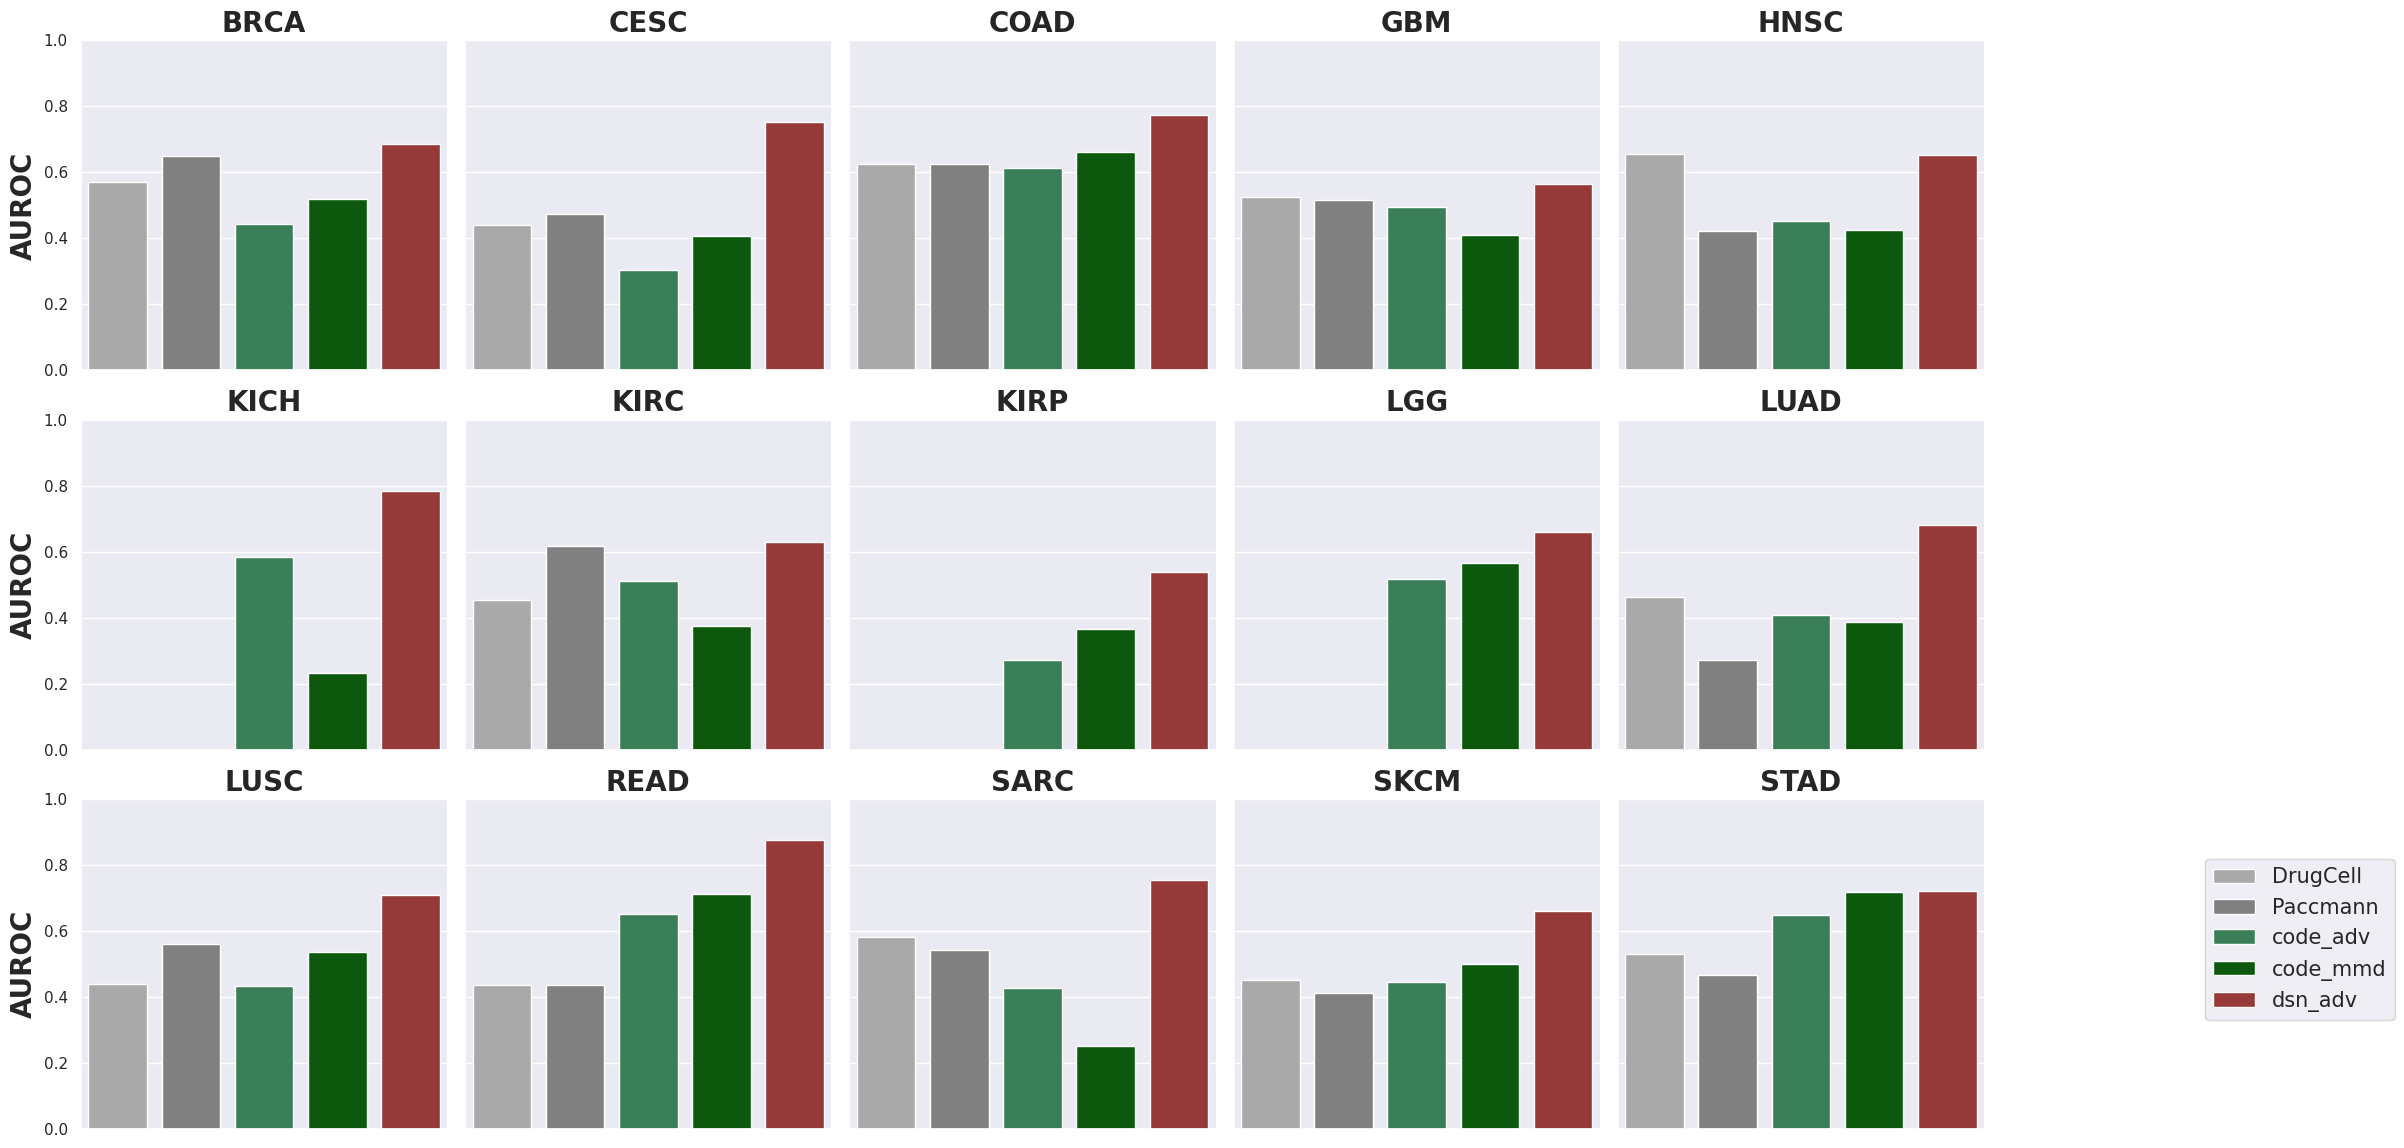

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

method_list = ['DrugCell','Paccmann','code_adv','code_mmd','dsn_adv']
color_list = ['darkgray','grey',
                'seagreen','darkgreen', #,'limegreen'
            #   'mediumpurple','purple',goldenrod','orange',
            'brown'] #,'gold'

palette ={method_list[i]:color_list[i] for i in range(len(method_list))}

plt.figure(figsize=(10, 12))
sns.set(font_scale = 3.5)
sns.set(rc={'figure.figsize':(6,14)})

g = sns.FacetGrid(b, col="variable", col_wrap=5, height=4)
g.map_dataframe(sns.barplot, x='Model', y='value', hue='Model', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=20, weight='bold')
g.set(ylim=(0.0,1.0))
g.set_xlabels('')
g.set_ylabels('AUROC', size=20, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(2.15, 0.85), fontsize=15)

plt.savefig('../a.pdf',format = 'pdf',dpi=600,bbox_inches='tight')
plt.show()


## C-MDL的三种方法对比（有重复版本）

In [1]:
import os
import pandas as pd
a = pd.DataFrame()
path = '../results/use_result/'
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            print(os.path.join(file))
            aa = pd.read_csv(os.path.join(root,file))
            aa.columns = ['Tumor_type','fc0','fc1','fc2','fc3','fc4']
            Model_name = file[6:-4]
            aa['method'] = Model_name
            a=pd.concat([a,aa])
            a.to_csv(os.path.join(path,'C_MDL.txt'))

a

AUROC_TGSA_model_mu.csv
AUROC_DrugCell_model.csv
AUROC_Paccmann_model.csv
AUROC_TGSA_model_exp.csv
AUROC_TGSA_model_exp_mu.csv


,Tumor_type,fc0,fc1,fc2,fc3,fc4,method
0,KICH_7,0.250000,0.333333,0.416667,0.250000,0.333333,TGSA_model_mu
1,KIRP_12,0.347222,0.486111,0.472222,0.486111,0.486111,TGSA_model_mu
2,LGG_118,0.380350,0.394283,0.418271,0.367423,0.560758,TGSA_model_mu
3,BRCA_28,0.390306,0.436224,0.446429,0.420918,0.461735,TGSA_model_mu
4,CESC_24,0.575758,0.598485,0.621212,0.674242,0.606061,TGSA_model_mu
...,...,...,...,...,...,...,...
11,PAAD_55,0.638049,0.510989,0.573489,0.586538,0.467720,TGSA_model_exp_mu
12,READ_8,0.687500,0.750000,0.812500,0.437500,0.500000,TGSA_model_exp_mu
13,SARC_30,0.508889,0.460000,0.524444,0.513333,0.524444,TGSA_model_exp_mu
14,SKCM_56,0.399235,0.479592,0.519770,0.496173,0.523597,TGSA_model_exp_mu


In [2]:
b = pd.melt(a,id_vars=['Tumor_type','method'],value_name='auroc')
b = b[['method','auroc','Tumor_type']]  ##还有一个variable是fc，从0到4
b['Tumor_type'] = [tt.split("_")[0] for tt in b['Tumor_type']]
b.sort_values(by=['method','Tumor_type'], inplace=True)

b

,method,auroc,Tumor_type
19,DrugCell_model,0.510204,BRCA
99,DrugCell_model,0.637755,BRCA
179,DrugCell_model,0.642857,BRCA
259,DrugCell_model,0.545918,BRCA
339,DrugCell_model,0.647959,BRCA
...,...,...,...
15,TGSA_model_mu,0.488889,STAD
95,TGSA_model_mu,0.373333,STAD
175,TGSA_model_mu,0.368889,STAD
255,TGSA_model_mu,0.431111,STAD


In [3]:
P_MDL = pd.read_csv('../results/use_result/P_MDL.txt',index_col = 0)
P_MDL = P_MDL.loc[P_MDL.method == 'dsn_adv_norm']
P_MDL.drop(P_MDL.columns[-1], axis=1, inplace=True)

P_MDL

,method,auroc,Tumor_type
39,dsn_adv_norm,0.668367,BRCA
36,dsn_adv_norm,0.693878,BRCA
38,dsn_adv_norm,0.704082,BRCA
37,dsn_adv_norm,0.678571,BRCA
35,dsn_adv_norm,0.678571,BRCA
...,...,...,...
36,dsn_adv_norm,0.768889,STAD
37,dsn_adv_norm,0.711111,STAD
38,dsn_adv_norm,0.720000,STAD
35,dsn_adv_norm,0.693333,STAD


In [15]:
Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kirc","lgg",
          "luad", "lusc",  "read", "sarc", "skcm","stad"]
Tumor_type_list = [element.upper() for element in Tumor_type_list]

MDL = pd.concat([b,P_MDL])
MDL = MDL.loc[MDL.Tumor_type.isin(Tumor_type_list)]
MDL.sort_values(by=['method','Tumor_type'],key = lambda x: x.map({'DrugCell_model':1, 'Paccmann_model':2, 'TGSA_model_mu':3,'TGSA_model_exp':4,
       'TGSA_model_exp_mu':5,  'dsn_adv_norm':6}), inplace=True)
# MDL.sort_values(by='Tumor_type' , inplace=True)
MDL

,method,auroc,Tumor_type
19,DrugCell_model,0.510204,BRCA
99,DrugCell_model,0.637755,BRCA
179,DrugCell_model,0.642857,BRCA
259,DrugCell_model,0.545918,BRCA
339,DrugCell_model,0.647959,BRCA
...,...,...,...
36,dsn_adv_norm,0.768889,STAD
37,dsn_adv_norm,0.711111,STAD
38,dsn_adv_norm,0.720000,STAD
35,dsn_adv_norm,0.693333,STAD


<Figure size 1000x1200 with 0 Axes>

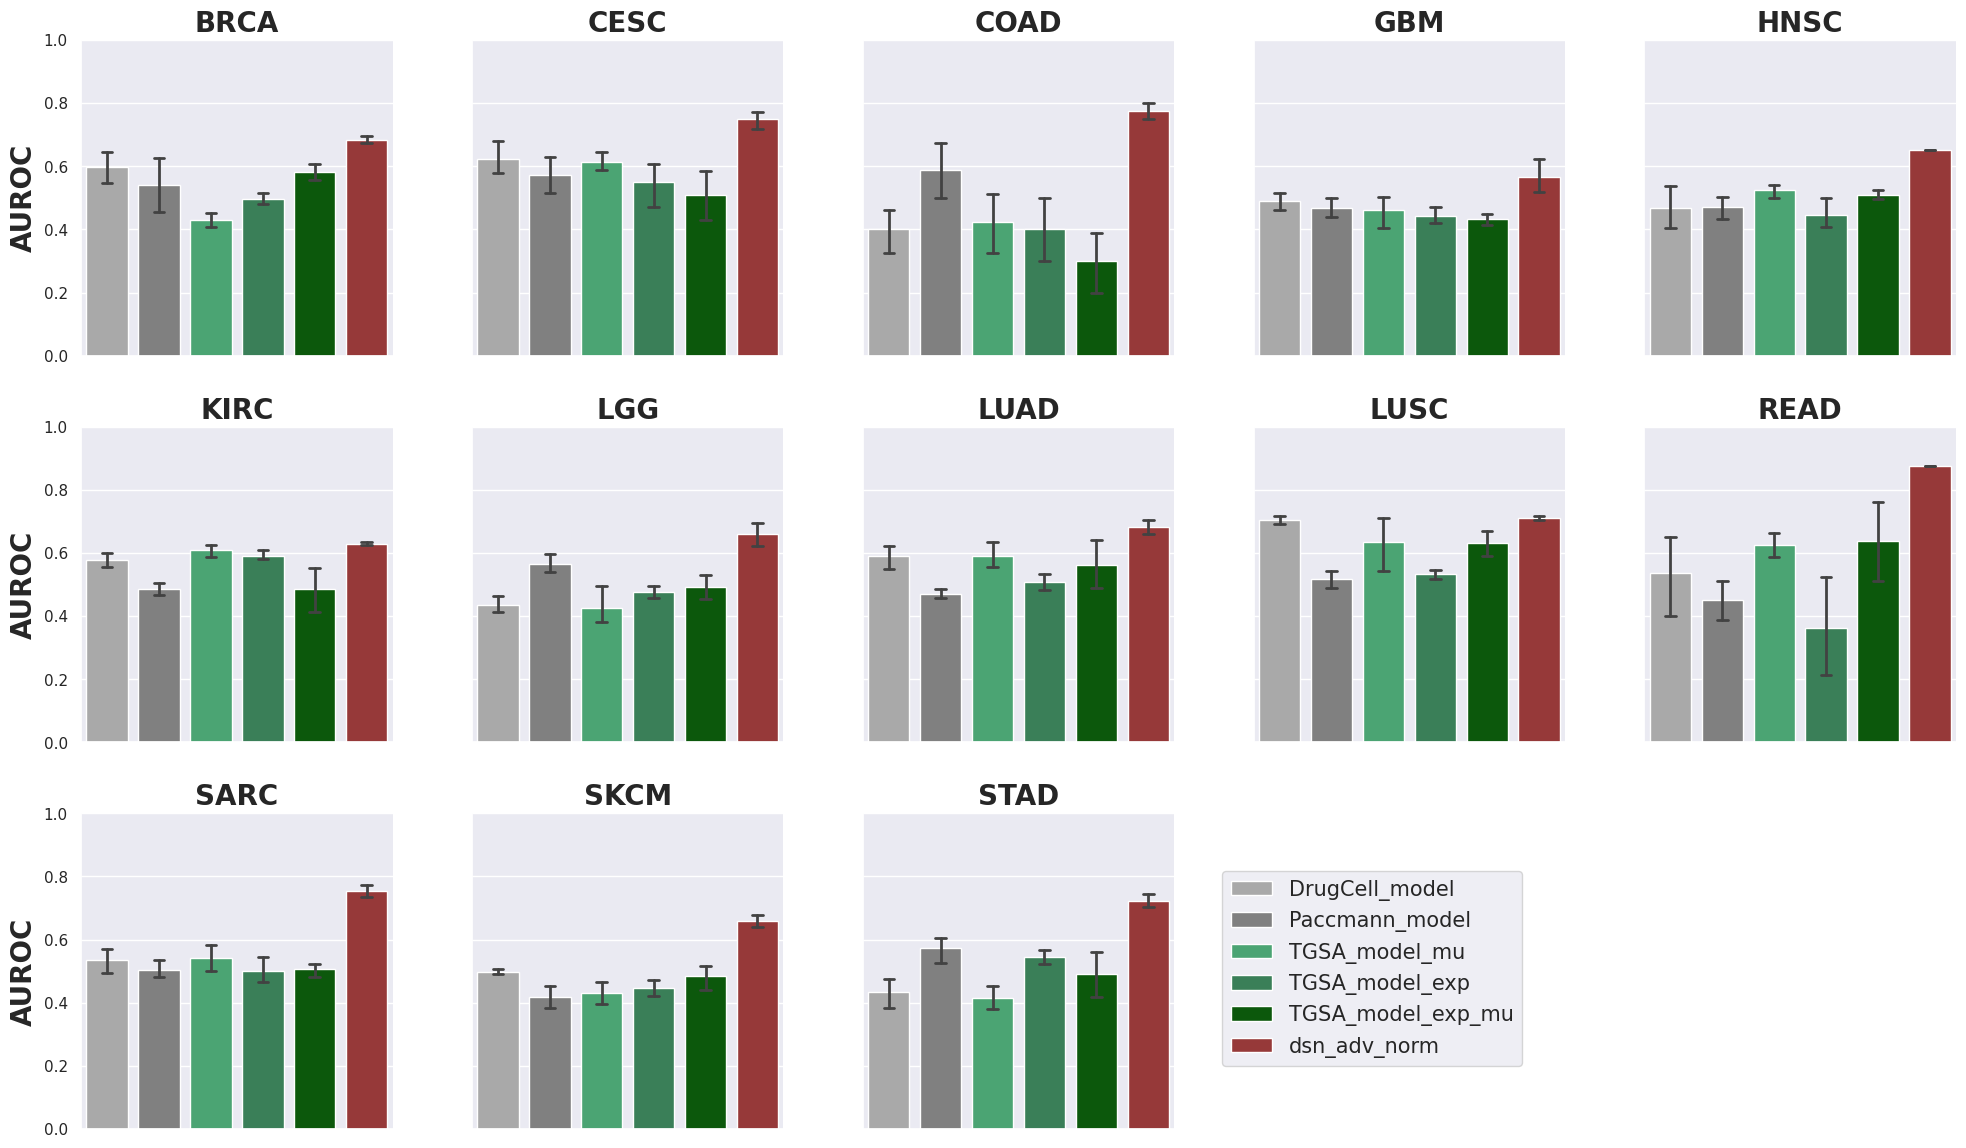

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

method_list = MDL.method.unique()
color_list = ['darkgray','grey',
                'mediumseagreen','seagreen','darkgreen', 
              #'mediumpurple', #'purple',#'goldenrod','orange',
            'brown'] #,'gold'

palette ={method_list[i]:color_list[i] for i in range(len(method_list))}

plt.figure(figsize=(10, 12))
sns.set(font_scale = 3.5)
sns.set(rc={'figure.figsize':(6,14)})

g = sns.FacetGrid(MDL, col="Tumor_type", col_wrap=5, height=4)
g.map_dataframe(sns.barplot, x='method', y='auroc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=20, weight='bold')
g.set(ylim=(0.0,1.0))
g.set_xlabels('')
g.set_ylabels('AUROC', size=20, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(2.15, 0.85), fontsize=15)

plt.savefig('../results/use_result/output/MDL_compare.pdf',format = 'pdf',dpi=600,bbox_inches='tight')
plt.show()


In [28]:
MDL_final = MDL.groupby(['method','Tumor_type'])['auroc'].mean()
MDL_final = pd.DataFrame(MDL_final)
# MDL_final.columns = ['method','Tumor_type','auroc']
MDL_final = pd.pivot_table(MDL_final,values='auroc',index='Tumor_type',columns='method')
MDL_final
MDL_final.to_csv('../results/use_result/output/MDL_final.csv')

## P-SDL的5种方法对比（有重复版本）

In [36]:
import pandas as pd
P_SDL = pd.read_csv('../results/use_result/final_all_drug_all.csv',index_col=0)
P_SDL.columns = ['Tumor_type','method','auroc']
P_SDL = P_SDL[['method','auroc','Tumor_type']]
P_SDL

,method,auroc,Tumor_type
0,code_adv,0.520408,BRCA
1,code_adv,0.368056,CESC
2,code_adv,0.500000,COAD
3,code_adv,0.523529,GBM
4,code_adv,0.345850,HNSC
...,...,...,...
0,dsna,0.489802,LGG
1,dsna,0.579431,LGG
2,dsna,0.464809,LGG
3,dsna,0.417983,LGG


In [37]:
P_MDL = pd.read_csv('../results/use_result/P_MDL.txt',index_col = 0)
P_MDL = P_MDL.loc[P_MDL.method == 'dsn_adv_norm']
P_MDL.drop(P_MDL.columns[-1], axis=1, inplace=True)

P_MDL

,method,auroc,Tumor_type
39,dsn_adv_norm,0.668367,BRCA
36,dsn_adv_norm,0.693878,BRCA
38,dsn_adv_norm,0.704082,BRCA
37,dsn_adv_norm,0.678571,BRCA
35,dsn_adv_norm,0.678571,BRCA
...,...,...,...
36,dsn_adv_norm,0.768889,STAD
37,dsn_adv_norm,0.711111,STAD
38,dsn_adv_norm,0.720000,STAD
35,dsn_adv_norm,0.693333,STAD


In [38]:
Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kirc","lgg",
          "luad", "lusc",  "read", "sarc", "skcm","stad"]
Tumor_type_list = [element.upper() for element in Tumor_type_list]

PP = pd.concat([P_SDL,P_MDL])
PP = PP.loc[PP.Tumor_type.isin(Tumor_type_list)]
PP.sort_values(by=['method','Tumor_type'],key = lambda x: x.map({'dsn':1, 'dsna':2, 'code_base':3,'code_mmd':4,
       'code_adv':5,  'dsn_adv_norm':6}), inplace=True)
# MDL.sort_values(by='Tumor_type' , inplace=True)
PP

,method,auroc,Tumor_type
0,dsn,0.622449,BRCA
1,dsn,0.333333,CESC
2,dsn,0.562500,COAD
3,dsn,0.398319,GBM
4,dsn,0.537549,HNSC
...,...,...,...
36,dsn_adv_norm,0.768889,STAD
37,dsn_adv_norm,0.711111,STAD
38,dsn_adv_norm,0.720000,STAD
35,dsn_adv_norm,0.693333,STAD


<Figure size 1000x1200 with 0 Axes>

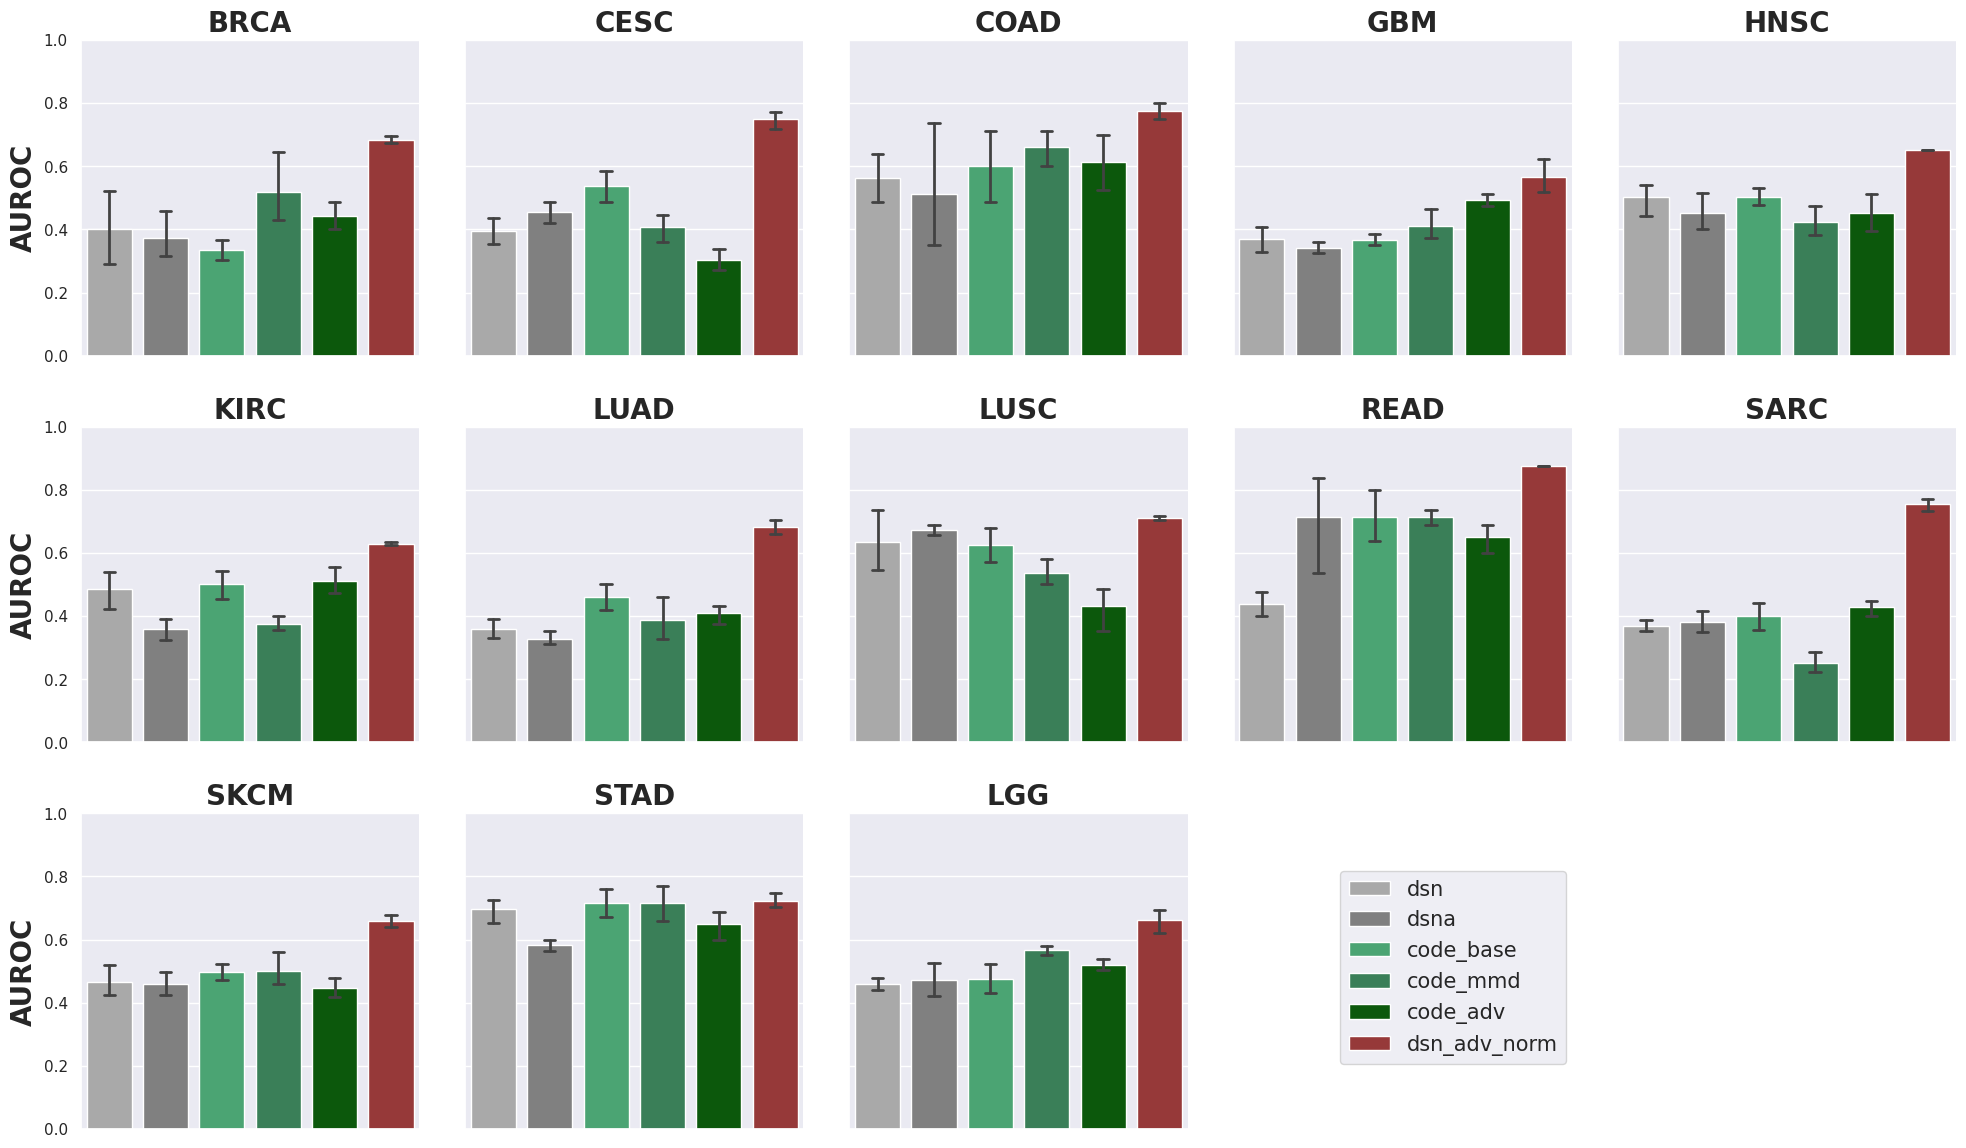

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

method_list = PP.method.unique()
color_list = ['darkgray','grey',
                'mediumseagreen','seagreen','darkgreen', 
              #'mediumpurple', #'purple',#'goldenrod','orange',
            'brown'] #,'gold'

palette ={method_list[i]:color_list[i] for i in range(len(method_list))}

plt.figure(figsize=(10, 12))
sns.set(font_scale = 3.5)
sns.set(rc={'figure.figsize':(6,14)})

g = sns.FacetGrid(PP, col="Tumor_type", col_wrap=5, height=4)
g.map_dataframe(sns.barplot, x='method', y='auroc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=20, weight='bold')
g.set(ylim=(0.0,1.0))
g.set_xlabels('')
g.set_ylabels('AUROC', size=20, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(2.15, 0.85), fontsize=15)

plt.savefig('../results/use_result/output/PP_compare.pdf',format = 'pdf',dpi=600,bbox_inches='tight')
plt.show()


In [42]:
PP_final = PP.groupby(['method','Tumor_type'])['auroc'].mean()
PP_final = pd.DataFrame(PP_final)
# PP_final.columns = ['method','Tumor_type','auroc']
PP_final = pd.pivot_table(PP_final,values='auroc',index='Tumor_type',columns='method')
PP_final
PP_final.to_csv('../results/use_result/output/PP_final.csv')

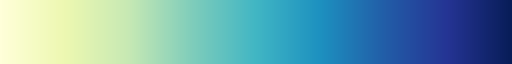

In [1]:
import matplotlib.pyplot as plt
plt.cm.YlGnBu

['# 9DCF97', '#71BC73', '#42A35B', '#248544', '#0F562E', 
'#9BC4DA', '#69A6CC', '#428ABA', '#236BA9', '#074D93', 
'#903838]


## P-MDL vs all 有重复版本

In [1]:
import os
import pandas as pd
# a = pd.DataFrame()
# path = '../results/use_result/'
# for root, dirs, files in os.walk(path):
#     for file in files:
#         if file.endswith('.csv'):
#             print(os.path.join(file))
#             aa = pd.read_csv(os.path.join(root,file))
#             aa.columns = ['Tumor_type','fc0','fc1','fc2','fc3','fc4']
#             Model_name = file[6:-4]
#             aa['method'] = Model_name
#             a=pd.concat([a,aa])
#             # a.to_csv(os.path.join(path,'C_MDL.txt'))

a = pd.read_csv('../results/use_result/C_MDL.txt',index_col=0)
a

,Tumor_type,fc0,fc1,fc2,fc3,fc4,method
0,KICH_7,0.250000,0.333333,0.416667,0.250000,0.333333,TGSA_model_mu
1,KIRP_12,0.347222,0.486111,0.472222,0.486111,0.486111,TGSA_model_mu
2,LGG_118,0.380350,0.394283,0.418271,0.367423,0.560758,TGSA_model_mu
3,BRCA_28,0.390306,0.436224,0.446429,0.420918,0.461735,TGSA_model_mu
4,CESC_24,0.575758,0.598485,0.621212,0.674242,0.606061,TGSA_model_mu
...,...,...,...,...,...,...,...
11,PAAD_55,0.638049,0.510989,0.573489,0.586538,0.467720,TGSA_model_exp_mu
12,READ_8,0.687500,0.750000,0.812500,0.437500,0.500000,TGSA_model_exp_mu
13,SARC_30,0.508889,0.460000,0.524444,0.513333,0.524444,TGSA_model_exp_mu
14,SKCM_56,0.399235,0.479592,0.519770,0.496173,0.523597,TGSA_model_exp_mu


In [2]:
b = pd.melt(a,id_vars=['Tumor_type','method'],value_name='auroc')
b = b[['method','auroc','Tumor_type']]  ##还有一个variable是fc，从0到4
b['Tumor_type'] = [tt.split("_")[0] for tt in b['Tumor_type']]
b.sort_values(by=['method','Tumor_type'], inplace=True)

b

,method,auroc,Tumor_type
19,DrugCell_model,0.510204,BRCA
99,DrugCell_model,0.637755,BRCA
179,DrugCell_model,0.642857,BRCA
259,DrugCell_model,0.545918,BRCA
339,DrugCell_model,0.647959,BRCA
...,...,...,...
15,TGSA_model_mu,0.488889,STAD
95,TGSA_model_mu,0.373333,STAD
175,TGSA_model_mu,0.368889,STAD
255,TGSA_model_mu,0.431111,STAD


In [3]:
P_MDL = pd.read_csv('../results/use_result/P_MDL.txt',index_col = 0)
P_MDL = P_MDL.loc[P_MDL.method == 'dsn_adv_norm']
P_MDL.drop(P_MDL.columns[-1], axis=1, inplace=True)

P_MDL

,method,auroc,Tumor_type
39,dsn_adv_norm,0.668367,BRCA
37,dsn_adv_norm,0.678571,BRCA
35,dsn_adv_norm,0.678571,BRCA
38,dsn_adv_norm,0.704082,BRCA
36,dsn_adv_norm,0.693878,BRCA
...,...,...,...
37,dsn_adv_norm,0.711111,STAD
36,dsn_adv_norm,0.768889,STAD
35,dsn_adv_norm,0.693333,STAD
38,dsn_adv_norm,0.720000,STAD


In [4]:
Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kirc","lgg",
          "luad", "lusc",  "read", "sarc", "skcm","stad"]
Tumor_type_list = [element.upper() for element in Tumor_type_list]

MDL = pd.concat([b,P_MDL])
MDL = MDL.loc[MDL.Tumor_type.isin(Tumor_type_list)]

# MDL.sort_values(by='Tumor_type' , inplace=True)
MDL

,method,auroc,Tumor_type
19,DrugCell_model,0.510204,BRCA
99,DrugCell_model,0.637755,BRCA
179,DrugCell_model,0.642857,BRCA
259,DrugCell_model,0.545918,BRCA
339,DrugCell_model,0.647959,BRCA
...,...,...,...
37,dsn_adv_norm,0.711111,STAD
36,dsn_adv_norm,0.768889,STAD
35,dsn_adv_norm,0.693333,STAD
38,dsn_adv_norm,0.720000,STAD


In [5]:
P_SDL = pd.read_csv('../results/use_result/final_all_drug_all.csv',index_col=0)
P_SDL.columns = ['Tumor_type','method','auroc']
P_SDL = P_SDL[['method','auroc','Tumor_type']]
P_SDL

,method,auroc,Tumor_type
0,code_adv,0.520408,BRCA
1,code_adv,0.368056,CESC
2,code_adv,0.500000,COAD
3,code_adv,0.523529,GBM
4,code_adv,0.345850,HNSC
...,...,...,...
0,dsna,0.489802,LGG
1,dsna,0.579431,LGG
2,dsna,0.464809,LGG
3,dsna,0.417983,LGG


In [6]:
Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kirc","lgg",
          "luad", "lusc",  "read", "sarc", "skcm","stad"]
Tumor_type_list = [element.upper() for element in Tumor_type_list]

PP = pd.concat([P_SDL,MDL])
PP = PP.loc[PP.Tumor_type.isin(Tumor_type_list)]
PP['Tumor_type'] = pd.Categorical(PP['Tumor_type'], categories=Tumor_type_list, ordered=True)
PP.sort_values(by=['method','Tumor_type'],key = lambda x: x.map({'dsn':1, 'dsna':2, 'code_base':3,'code_mmd':4,
       'code_adv':5, 'DrugCell_model':6, 'Paccmann_model':7, 'TGSA_model_mu':8,'TGSA_model_exp':9,
       'TGSA_model_exp_mu':10,  'dsn_adv_norm':11}), inplace=True)
# MDL.sort_values(by='Tumor_type' , inplace=True)
PP

,method,auroc,Tumor_type
0,dsn,0.622449,BRCA
1,dsn,0.333333,CESC
2,dsn,0.562500,COAD
3,dsn,0.398319,GBM
4,dsn,0.537549,HNSC
...,...,...,...
37,dsn_adv_norm,0.711111,STAD
36,dsn_adv_norm,0.768889,STAD
35,dsn_adv_norm,0.693333,STAD
38,dsn_adv_norm,0.720000,STAD


In [32]:
PP_recon = PP.groupby(['method', 'Tumor_type']).mean()
PP_recon.reset_index(inplace=True)
PP_table = PP_recon.pivot(index='method', columns='Tumor_type', values='auroc')
PP_table = PP_table.loc[['dsn', 'dsna', 'code_base','code_mmd','code_adv', 
                         'DrugCell_model', 'Paccmann_model', 'TGSA_model_mu','TGSA_model_exp',
       'TGSA_model_exp_mu',  'ae_norm']]
PP_table

1     CESC
2     COAD
3      GBM
4     HNSC
5     KIRC
6     LUAD
7     LUSC
9     READ
10    SARC
11    SKCM
12    STAD
13    BRCA
14    CESC
15    COAD
16     GBM
17    HNSC
18    KIRC
19    LUAD
20    LUSC
Name: Tumor_type, dtype: category
Categories (13, object): ['BRCA' < 'CESC' < 'COAD' < 'GBM' ... 'READ' < 'SARC' < 'SKCM' < 'STAD']

<Figure size 1000x1200 with 0 Axes>

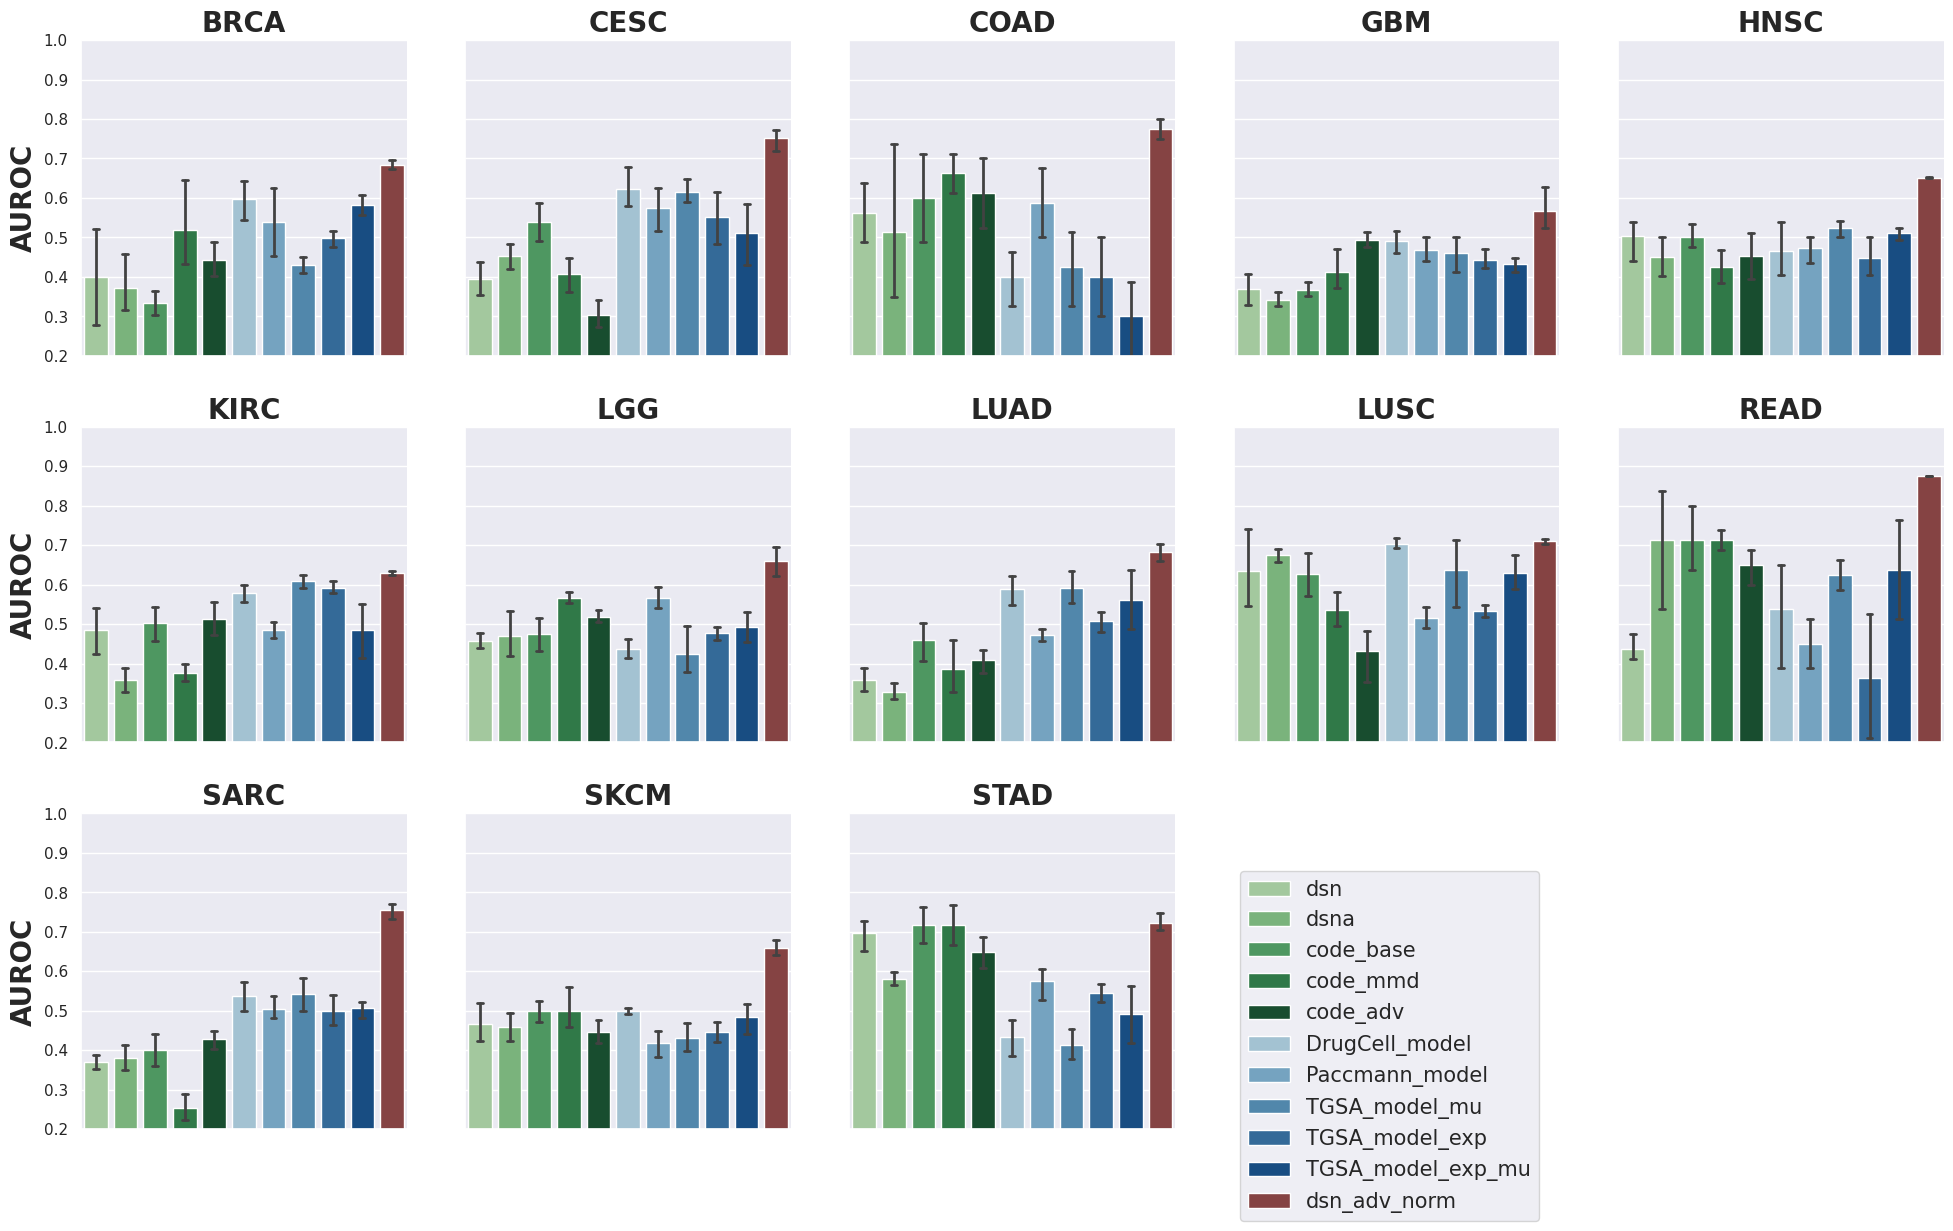

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

method_list = PP.method.unique()
color_list = ['#9DCF97', '#71BC73', '#42A35B', '#248544', '#0F562E', 
              '#9BC4DA', '#69A6CC', '#428ABA', '#236BA9', '#074D93', 
              '#903838']
# color_list = ['#9BC4DA', '#69A6CC', '#428ABA', '#236BA9', '#074D93', 
#               '#9DCF97', '#71BC73', '#42A35B', '#248544', '#0F562E', 
#               '#903838']

palette ={method_list[i]:color_list[i] for i in range(len(method_list))}

plt.figure(figsize=(10, 12))
sns.set(font_scale = 3.5)
sns.set(rc={'figure.figsize':(6,14)})

g = sns.FacetGrid(PP, col="Tumor_type", col_wrap=5, height=4)
g.map_dataframe(sns.barplot, x='method', y='auroc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=20, weight='bold')
g.set(ylim=(0.2,1.0))
g.set_xlabels('')
g.set_ylabels('AUROC', size=20, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(2.15, 0.85), fontsize=15)

plt.savefig('../results/use_result/output/PP_all.pdf',format = 'pdf',dpi=600,bbox_inches='tight')
plt.show()

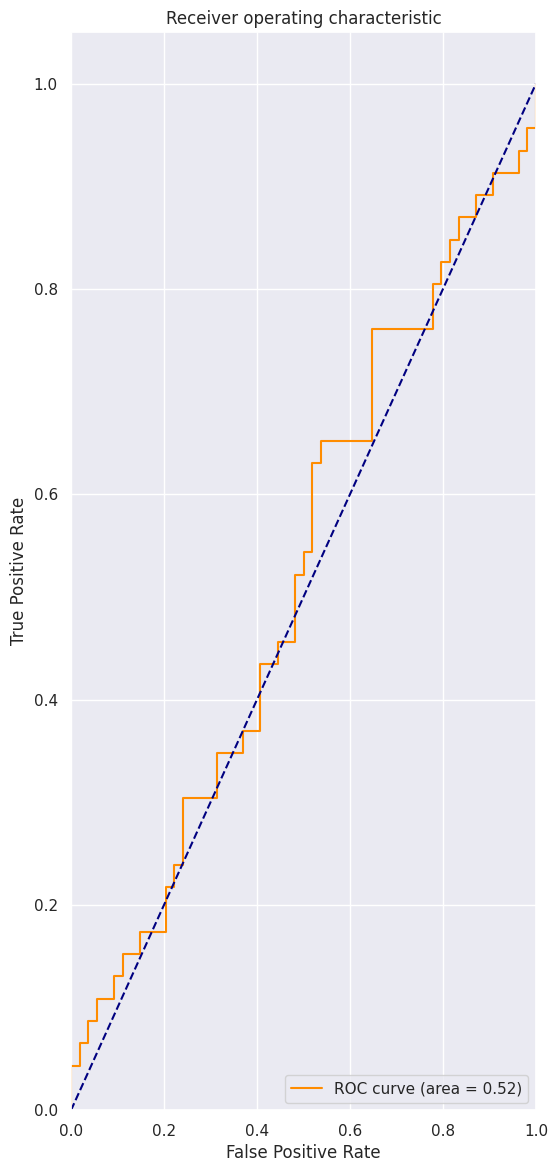

In [135]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# 随机生成真实标签和预测概率
y_true = np.random.randint(0, 2, size=100)
y_score = np.random.rand(100)

# y_score = np.multiply(np.array([0,1,0.4,0.5,0.6,0.7,0.8,0.9]),10)
# y_true = np.array([0,1,1,0,1,0,1,1])
# print(y_true)
# print(y_score)


# 计算ROC曲线和AUC值
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# 画ROC曲线
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")




KeyboardInterrupt: 

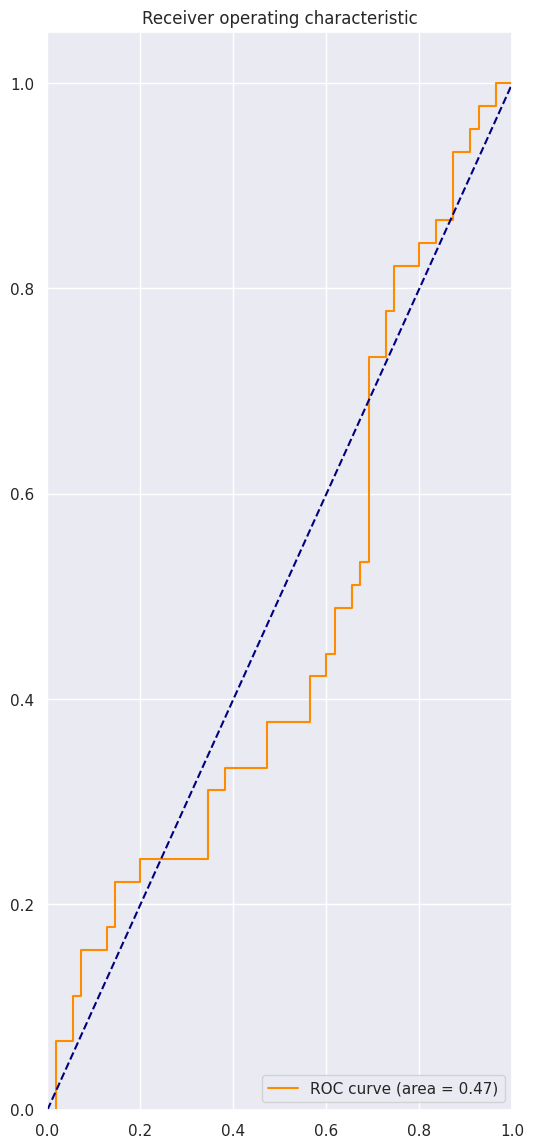

In [128]:
# 判断AUC是否大于0.8，如果不是则重新生成数据和曲线
while roc_auc < 0.7:
    y_true = np.random.randint(0, 2, size=100)
    y_score = np.random.rand(100)
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.clf()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

plt.show()

## Fig1 AE_tcga vs all others

In [54]:
import os
import pandas as pd


a = pd.read_csv('../results/use_result/C_MDL.txt',index_col=0)
b = pd.melt(a,id_vars=['Tumor_type','method'],value_name='auroc')
b = b[['method','auroc','Tumor_type']]  ##还有一个variable是fc，从0到4
b['Tumor_type'] = [tt.split("_")[0] for tt in b['Tumor_type']]
b.sort_values(by=['method','Tumor_type'], inplace=True)

P_MDL = pd.read_csv('../results/use_result/P_MDL_tcga.txt',index_col = 0)
# P_MDL = P_MDL.loc[P_MDL.method == 'ae_norm']
P_MDL.drop(P_MDL.columns[-1], axis=1, inplace=True)

Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kirc","lgg",
          "luad", "lusc",  "read", "sarc", "skcm","stad"]
Tumor_type_list = [element.upper() for element in Tumor_type_list]

MDL = pd.concat([b,P_MDL])
MDL = MDL.loc[MDL.Tumor_type.isin(Tumor_type_list)]

P_SDL = pd.read_csv('../results/use_result/final_all_drug_all.csv',index_col=0)
P_SDL.columns = ['Tumor_type','method','auroc']
P_SDL = P_SDL[['method','auroc','Tumor_type']]

PP = pd.concat([P_SDL,MDL])
PP = PP.loc[PP.Tumor_type.isin(Tumor_type_list)]
PP['Tumor_type'] = pd.Categorical(PP['Tumor_type'], categories=Tumor_type_list, ordered=True)
PP.sort_values(by=['method','Tumor_type'],key = lambda x: x.map({'dsn':1, 'dsna':2, 'code_base':3,'code_mmd':4,
       'code_adv':5, 'DrugCell_model':6, 'Paccmann_model':7, 'TGSA_model_mu':8,'TGSA_model_exp':9,
       'TGSA_model_exp_mu':10,  'ae_norm':11}), inplace=True)


import seaborn as sns
import matplotlib.pyplot as plt

method_list = PP.method.unique()
color_list = ['#9DCF97', '#71BC73', '#42A35B', '#248544', '#0F562E', 
              '#9BC4DA', '#69A6CC', '#428ABA', '#236BA9', '#074D93', 
              '#903838']
# color_list = ['#9BC4DA', '#69A6CC', '#428ABA', '#236BA9', '#074D93', 
#               '#9DCF97', '#71BC73', '#42A35B', '#248544', '#0F562E', 
#               '#903838']

palette ={method_list[i]:color_list[i] for i in range(len(method_list))}

plt.figure(figsize=(10, 12))
sns.set(font_scale = 3.5)
sns.set(rc={'figure.figsize':(6,14)})

g = sns.FacetGrid(PP, col="Tumor_type", col_wrap=5, height=4)
g.map_dataframe(sns.barplot, x='method', y='auroc', hue='method', palette=palette, errwidth=2.0, capsize=0.2,dodge=False)
g.despine()
g.set_titles('{col_name}', size=20, weight='bold')
g.set(ylim=(0.2,1.0))
g.set_xlabels('')
g.set_ylabels('AUROC', size=20, weight='bold')
g.set_xticklabels("")
plt.legend(loc='upper right', bbox_to_anchor=(2.15, 0.85), fontsize=15)

# plt.savefig('../results/use_result/output/PP_all.pdf',format = 'pdf',dpi=600,bbox_inches='tight')
plt.show()

IndexError: list index out of range

In [12]:
PP_recon = PP.groupby(['method', 'Tumor_type']).mean()
PP_recon.reset_index(inplace=True)
PP_table = PP_recon.pivot(index='method', columns='Tumor_type', values='auroc')
PP_table = PP_table.loc[['dsn', 'dsna', 'code_base','code_mmd','code_adv', 
                         'DrugCell_model', 'Paccmann_model', 'TGSA_model_mu','TGSA_model_exp',
       'TGSA_model_exp_mu',  'ae_norm']]
PP_table

Tumor_type,BRCA,CESC,COAD,GBM,HNSC,KIRC,LGG,LUAD,LUSC,READ,SARC,SKCM,STAD
method,,,,,,,,,,,,,
dsn,0.400000,0.395833,0.5625,0.369412,0.502767,0.485507,0.458317,0.359091,0.634,0.4375,0.368889,0.466071,0.696000
dsna,0.372449,0.454167,0.5125,0.342185,0.451383,0.358333,0.470957,0.328788,0.674,0.7125,0.381333,0.459949,0.581333
code_base,0.334694,0.538889,0.6000,0.367563,0.501976,0.502174,0.473714,0.460606,0.626,0.7125,0.400889,0.498214,0.717333
code_mmd,0.518367,0.408333,0.6625,0.411261,0.424506,0.375362,0.566102,0.386364,0.536,0.7125,0.252444,0.500255,0.717333
code_adv,0.442857,0.304167,0.6125,0.494286,0.452964,0.511594,0.518529,0.409091,0.432,0.6500,0.427556,0.445408,0.648889
DrugCell_model,0.596939,0.623485,0.4000,0.490168,0.466403,0.578623,0.436369,0.589394,0.704,0.5375,0.536889,0.498724,0.432889
Paccmann_model,0.539796,0.573611,0.5875,0.469076,0.471937,0.484783,0.566274,0.471212,0.516,0.4500,0.504889,0.417602,0.574222
TGSA_model_mu,0.431122,0.615152,0.4250,0.460672,0.524111,0.607971,0.424217,0.590909,0.636,0.6250,0.541333,0.431122,0.414222
TGSA_model_exp,0.497449,0.550758,0.4000,0.443025,0.447233,0.591304,0.476271,0.506818,0.532,0.3625,0.499111,0.445153,0.545333


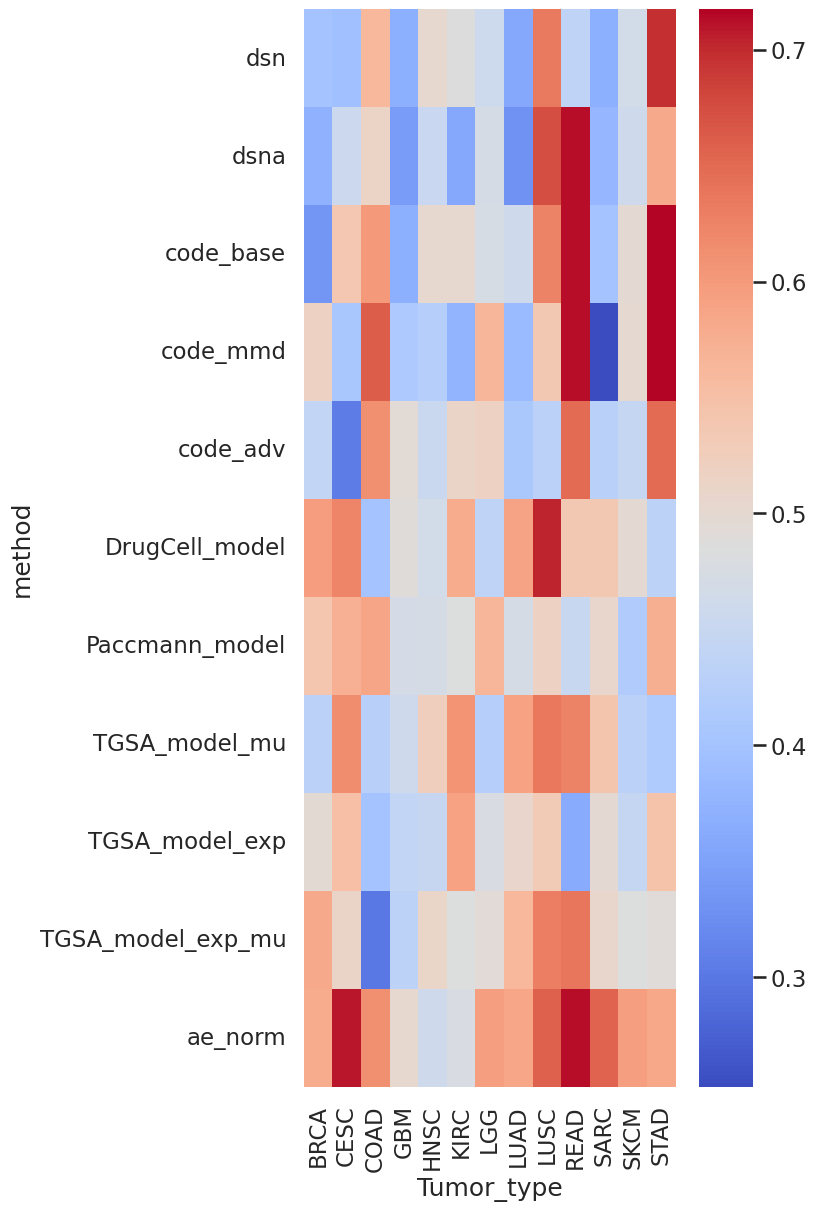

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# 将 DataFrame 转换为二维数组
# heatmap_data = pd.pivot_table(df, values='value', index='row', columns='column')

# 绘制热力图
sns.set_context(rc={'figure.figsize':(4,4)})  # 设置图像尺寸，宽度为 12 英寸，高度为 8 英寸
sns.heatmap(PP_table, cmap='coolwarm')

# 设置图像属性
# plt.title('Heatmap Title')
# plt.xlabel('X Label')
# plt.ylabel('Y Label')
plt.savefig('../results/use_result/output/PP_tcga_ae.pdf',format = 'pdf',dpi=600,bbox_inches='tight')


In [25]:
PP_table.loc['adv/max'] = PP_table.iloc[10,].div(PP_table.max(axis=0))
PP_table

Tumor_type,BRCA,CESC,COAD,GBM,HNSC,KIRC,LGG,LUAD,LUSC,READ,SARC,SKCM,STAD
method,,,,,,,,,,,,,
dsn,0.400000,0.395833,0.5625,0.369412,0.502767,0.485507,0.458317,0.359091,0.634,0.4375,0.368889,0.466071,0.696000
dsna,0.372449,0.454167,0.5125,0.342185,0.451383,0.358333,0.470957,0.328788,0.674,0.7125,0.381333,0.459949,0.581333
code_base,0.334694,0.538889,0.6000,0.367563,0.501976,0.502174,0.473714,0.460606,0.626,0.7125,0.400889,0.498214,0.717333
code_mmd,0.518367,0.408333,0.6625,0.411261,0.424506,0.375362,0.566102,0.386364,0.536,0.7125,0.252444,0.500255,0.717333
code_adv,0.442857,0.304167,0.6125,0.494286,0.452964,0.511594,0.518529,0.409091,0.432,0.6500,0.427556,0.445408,0.648889
DrugCell_model,0.596939,0.623485,0.4000,0.490168,0.466403,0.578623,0.436369,0.589394,0.704,0.5375,0.536889,0.498724,0.432889
Paccmann_model,0.539796,0.573611,0.5875,0.469076,0.471937,0.484783,0.566274,0.471212,0.516,0.4500,0.504889,0.417602,0.574222
TGSA_model_mu,0.431122,0.615152,0.4250,0.460672,0.524111,0.607971,0.424217,0.590909,0.636,0.6250,0.541333,0.431122,0.414222
TGSA_model_exp,0.497449,0.550758,0.4000,0.443025,0.447233,0.591304,0.476271,0.506818,0.532,0.3625,0.499111,0.445153,0.545333


In [28]:
PP_table.idxmax()

Tumor_type
BRCA    DrugCell_model
CESC           ae_norm
COAD          code_mmd
GBM            ae_norm
HNSC     TGSA_model_mu
KIRC     TGSA_model_mu
LGG            ae_norm
LUAD     TGSA_model_mu
LUSC    DrugCell_model
READ              dsna
SARC           ae_norm
SKCM           ae_norm
STAD          code_mmd
dtype: object

In [7]:
import pandas as pd

a = pd.read_csv('../results/use_result/C_MDL.txt',index_col=0)
b = pd.melt(a,id_vars=['Tumor_type','method'],value_name='auroc')
b = b[['method','auroc','Tumor_type']]  ##还有一个variable是fc，从0到4
b['Tumor_type'] = [tt.split("_")[0] for tt in b['Tumor_type']]
b.sort_values(by=['method','Tumor_type'], inplace=True)

P_MDL = pd.read_csv('../results/use_result/P_MDL_store.csv',index_col = 0)
# P_MDL = P_MDL.loc[P_MDL.method == 'ae_norm']
P_MDL.drop(P_MDL.columns[-1], axis=1, inplace=True)

Tumor_type_list = ["brca", "cesc", "coad", "gbm", "hnsc", "kirc","lgg",
          "luad", "lusc",  "read", "sarc", "skcm","stad"]
Tumor_type_list = [element.upper() for element in Tumor_type_list]

MDL = pd.concat([b,P_MDL])
MDL = MDL.loc[MDL.Tumor_type.isin(Tumor_type_list)]

P_SDL = pd.read_csv('../results/use_result/final_all_drug_all.csv',index_col=0)
P_SDL.columns = ['Tumor_type','method','auroc']
P_SDL = P_SDL[['method','auroc','Tumor_type']]

PP = pd.concat([P_SDL,MDL])
PP = PP.loc[PP.Tumor_type.isin(Tumor_type_list)]
PP['Tumor_type'] = pd.Categorical(PP['Tumor_type'], categories=Tumor_type_list, ordered=True)
PP

,method,auroc,Tumor_type
0,code_adv,0.520408,BRCA
1,code_adv,0.368056,CESC
2,code_adv,0.500000,COAD
3,code_adv,0.523529,GBM
4,code_adv,0.345850,HNSC
...,...,...,...
36,dsn_adv_norm,0.768889,STAD
37,dsn_adv_norm,0.711111,STAD
38,dsn_adv_norm,0.720000,STAD
35,dsn_adv_norm,0.693333,STAD


In [8]:
PP_recon = PP.groupby(['method', 'Tumor_type']).mean()
PP_recon.reset_index(inplace=True)
PP_table = PP_recon.pivot(index='method', columns='Tumor_type', values='auroc')
PP_table = PP_table.loc[['dsn', 'dsna', 'code_base','code_mmd','code_adv', 
                         'DrugCell_model', 'Paccmann_model', 'TGSA_model_mu','TGSA_model_exp',
       'TGSA_model_exp_mu',  'ae_norm','dsrn_norm','ae_mmd_norm','dsrn_mmd_norm','dsn_mmd_norm',
       'ae_adv_norm','dsrn_adv_norm','dsn_adv_norm']]

Tumor_type,BRCA,CESC,COAD,GBM,HNSC,KIRC,LGG,LUAD,LUSC,READ,SARC,SKCM,STAD
method,,,,,,,,,,,,,
dsn,0.400000,0.395833,0.5625,0.369412,0.502767,0.485507,0.458317,0.359091,0.634,0.4375,0.368889,0.466071,0.696000
dsna,0.372449,0.454167,0.5125,0.342185,0.451383,0.358333,0.470957,0.328788,0.674,0.7125,0.381333,0.459949,0.581333
code_base,0.334694,0.538889,0.6000,0.367563,0.501976,0.502174,0.473714,0.460606,0.626,0.7125,0.400889,0.498214,0.717333
code_mmd,0.518367,0.408333,0.6625,0.411261,0.424506,0.375362,0.566102,0.386364,0.536,0.7125,0.252444,0.500255,0.717333
code_adv,0.442857,0.304167,0.6125,0.494286,0.452964,0.511594,0.518529,0.409091,0.432,0.6500,0.427556,0.445408,0.648889
DrugCell_model,0.596939,0.623485,0.4000,0.490168,0.466403,0.578623,0.436369,0.589394,0.704,0.5375,0.536889,0.498724,0.432889
Paccmann_model,0.539796,0.573611,0.5875,0.469076,0.471937,0.484783,0.566274,0.471212,0.516,0.4500,0.504889,0.417602,0.574222
TGSA_model_mu,0.431122,0.615152,0.4250,0.460672,0.524111,0.607971,0.424217,0.590909,0.636,0.6250,0.541333,0.431122,0.414222
TGSA_model_exp,0.497449,0.550758,0.4000,0.443025,0.447233,0.591304,0.476271,0.506818,0.532,0.3625,0.499111,0.445153,0.545333


In [13]:
PP_max = pd.DataFrame({
    "P-SDL":PP_table.iloc[0:4,:].max(axis=0),
    "C-MDL":PP_table.iloc[5:9,:].max(axis=0),
    "P-MDL":PP_table.iloc[17,:]
    })
PP_max

,P-SDL,C-MDL,P-MDL
Tumor_type,,,
BRCA,0.518367,0.596939,0.684694
CESC,0.538889,0.623485,0.751389
COAD,0.662500,0.587500,0.775000
GBM,0.411261,0.490168,0.565714
HNSC,0.502767,0.524111,0.651383
KIRC,0.502174,0.607971,0.628623
LGG,0.566102,0.566274,0.660500
LUAD,0.460606,0.590909,0.681818
LUSC,0.674000,0.704000,0.710000


In [23]:
PP_max['over_PSDL'] = (PP_max['P-MDL'] / PP_max['P-SDL'] - 1 )*100
PP_max['over_CMDL'] = (PP_max['P-MDL'] / PP_max['C-MDL'] - 1 )*100
PP_max['over_all'] = (PP_max['P-MDL'] / PP_max[['P-SDL','C-MDL']].max(axis=1) - 1 )*100

PP_max

,P-SDL,C-MDL,P-MDL,over_PSDL,over_CMDL,over_all
Tumor_type,,,,,,
BRCA,0.518367,0.596939,0.684694,32.086614,14.700855,14.700855
CESC,0.538889,0.623485,0.751389,39.432990,20.514378,20.514378
COAD,0.662500,0.587500,0.775000,16.981132,31.914894,16.981132
GBM,0.411261,0.490168,0.565714,37.556191,15.412309,15.412309
HNSC,0.502767,0.524111,0.651383,29.559748,24.283560,24.283560
KIRC,0.502174,0.607971,0.628623,25.180375,3.396901,3.396901
LGG,0.566102,0.566274,0.660500,16.675124,16.639610,16.639610
LUAD,0.460606,0.590909,0.681818,48.026316,15.384615,15.384615
LUSC,0.674000,0.704000,0.710000,5.341246,0.852273,0.852273


In [24]:
PP_table.to_csv('../results/use_result/comp/PP_table.csv')
PP_max.to_csv('../results/use_result/comp/PP_max.csv')


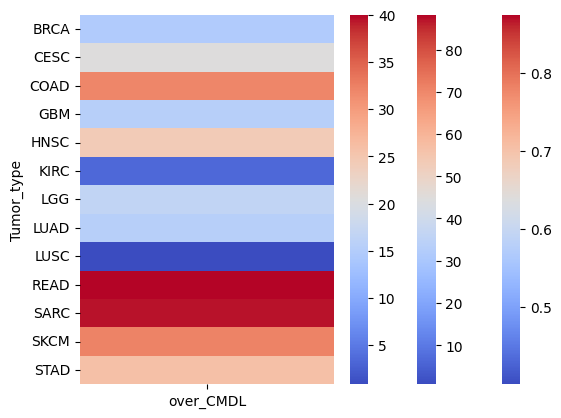

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# 绘制热力图
sns.set_context(rc={'figure.figsize':(4,4)})  # 设置图像尺寸，宽度为 12 英寸，高度为 8 英寸
sns.heatmap(PP_max.iloc[:,0:3], cmap='coolwarm')

# 设置图像属性
# plt.title('Heatmap Title')
# plt.xlabel('X Label')
# plt.ylabel('Y Label')
plt.savefig('../results/use_result/comp/PP_comp.pdf',format = 'pdf',dpi=600,bbox_inches='tight')


sns.set_context(rc={'figure.figsize':(4,4)})  # 设置图像尺寸，宽度为 12 英寸，高度为 8 英寸
sns.heatmap(PP_max.iloc[:,3:4], cmap='coolwarm')
plt.savefig('../results/use_result/comp/PP_over_PSDL.pdf',format = 'pdf',dpi=600,bbox_inches='tight')

sns.set_context(rc={'figure.figsize':(4,4)})  # 设置图像尺寸，宽度为 12 英寸，高度为 8 英寸
sns.heatmap(PP_max.iloc[:,4:5], cmap='coolwarm')
plt.savefig('../results/use_result/comp/PP_over_CMDL.pdf',format = 'pdf',dpi=600,bbox_inches='tight')


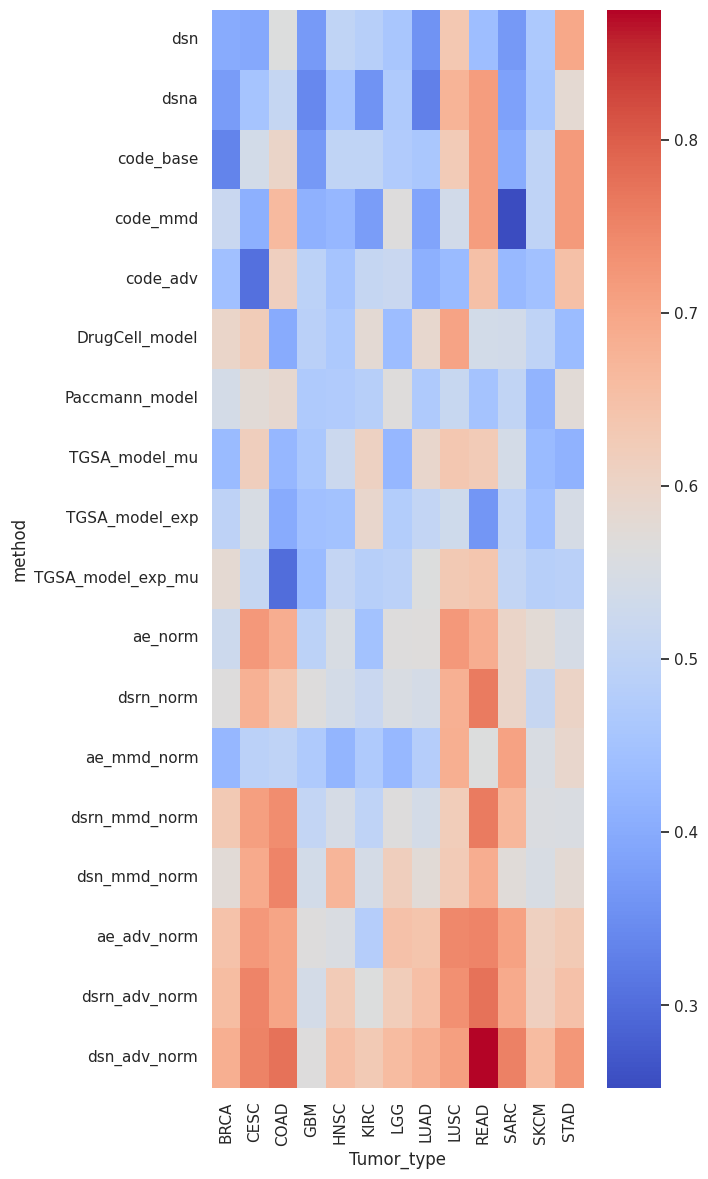

In [64]:
PP_recon = PP.groupby(['method', 'Tumor_type']).mean()
PP_recon.reset_index(inplace=True)
PP_table = PP_recon.pivot(index='method', columns='Tumor_type', values='auroc')
PP_table = PP_table.loc[['dsn', 'dsna', 'code_base','code_mmd','code_adv', 
                         'DrugCell_model', 'Paccmann_model', 'TGSA_model_mu','TGSA_model_exp',
       'TGSA_model_exp_mu',  'ae_norm','dsrn_norm','ae_mmd_norm','dsrn_mmd_norm','dsn_mmd_norm',
       'ae_adv_norm','dsrn_adv_norm','dsn_adv_norm']]

import seaborn as sns
import matplotlib.pyplot as plt

# 将 DataFrame 转换为二维数组
# heatmap_data = pd.pivot_table(df, values='value', index='row', columns='column')

# 绘制热力图
sns.set_context(rc={'figure.figsize':(4,4)})  # 设置图像尺寸，宽度为 12 英寸，高度为 8 英寸
sns.heatmap(PP_table, cmap='coolwarm')

# 设置图像属性
# plt.title('Heatmap Title')
# plt.xlabel('X Label')
# plt.ylabel('Y Label')
plt.savefig('../results/use_result/output/PP_TT_all.pdf',format = 'pdf',dpi=600,bbox_inches='tight')


In [65]:
PP_table.idxmax()

Tumor_type
BRCA    dsn_adv_norm
CESC    dsn_adv_norm
COAD    dsn_adv_norm
GBM        dsrn_norm
HNSC    dsn_mmd_norm
KIRC    dsn_adv_norm
LGG     dsn_adv_norm
LUAD    dsn_adv_norm
LUSC     ae_adv_norm
READ    dsn_adv_norm
SARC    dsn_adv_norm
SKCM    dsn_adv_norm
STAD    dsn_adv_norm
dtype: object